In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-12-26 11:53:38.117703: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-12-26 11:53:48.373406: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-12-26 11:53:48.385616: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-12-26 11:53:48.385650: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-12-26 11:53:48.388380: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-12-26 11:53:48.391185: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

# Load Koch Meinhardt dataset


In [2]:
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_2/Koch_Meinhardt_2.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)

In [3]:
data.shape

(2, 100, 100, 513)

In [4]:
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_2/simulation.txt")
with open(data_path, 'r') as f:
    simulation = eval(f.read())


In [5]:
t_star = np.linspace(simulation.t_start, 
                     simulation.t_end, 
                     simulation.t_steps)

#t_star = t_star[-3:-1]
#data = data[..., -3:-1]
T = t_star.shape[0]    

L = simulation.L[0]
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

In [6]:
c_t = np.array([[(data[c, ..., t+1] -  data[c, ..., t])/(t_star[t+1] - t_star[t])
                    for t in range(data.shape[3]-1)]
                    for c in range(data.shape[0])
                   ])
c_t = np.einsum("ctij -> cijt", c_t)

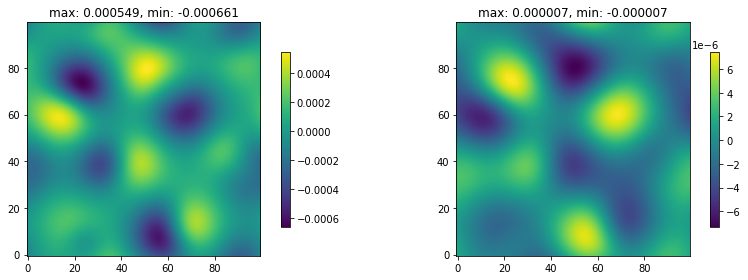

In [7]:
index = -1
_ = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title(f"max: {np.max(c_t[0,:,:, index]):.6f}, min: {np.min(c_t[0,:,:, index]):.6f}")
plt.imshow(c_t[0,:,:, index].T, origin='lower')
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.title(f"max: {np.max(c_t[1,:,:, index]):.6f}, min: {np.min(c_t[1,:,:, index]):.6f}")
plt.imshow(c_t[1,:,:, index].T, origin='lower')
plt.colorbar(shrink=.75)
plt.tight_layout()
plt.show()

In [8]:
data.shape

(2, 100, 100, 513)

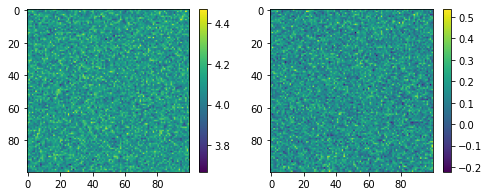

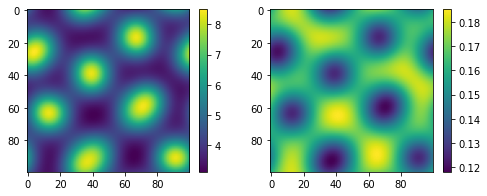

In [9]:
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, 0])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, 0])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, -1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, -1])
plt.colorbar(shrink=.75)
plt.show()

## Note: We use a prefactor to make the amplitude of u, v, u_xx, u_yy, u_t, v_xx, v_yy and v_t more or less in the same order of magnitude. And later, we do the inveres in solving the PDE. It is important for converging to the observed value.

In [10]:
# u, v, u_xx, u_yy, u_t, v_xx, v_yy, v_t
#outputs_correction_fact = [1, 1, .25, .25, 1000, 2.5, 2.5, 10000]
#xx_factors = [.25, 2.5]
#yy_factors = [.25, 2.5]
#t_factors = [1000, 10000]

dxdy = x_size*y_size/L**2
#c_xx =  np.array([[dxdy * simulation.Ds[c] * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
#c_xx =  np.array([[xx_factors[c] * dxdy  * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
c_xx =  np.array([[ dxdy  * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_xx = np.einsum("ctij -> cijt", c_xx)
#c_yy = np.array([[dxdy * simulation.Ds[c] * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
#c_yy = np.array([[yy_factors[c] * dxdy * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
c_yy = np.array([[ dxdy * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_yy = np.einsum("ctij -> cijt", c_yy)

#c_t = np.array([[data[c, ..., t] -  data[c, ..., t-1] if t > 0 else data[c, ..., t] -  pre_data[c, ..., 0]
#c_t = np.array([[t_factors[c] * (data[c, ..., t+1] -  data[c, ..., t])/(t_star[t+1] - t_star[t])
c_t = np.array([[(data[c, ..., t+1] -  data[c, ..., t])/(t_star[t+1] - t_star[t])
                    for t in range(data.shape[3]-1)]
                    for c in range(data.shape[0])
                   ])
c_t = np.einsum("ctij -> cijt", c_t)

In [11]:
dxdy = x_size*y_size/L**2
#diff_Y = np.array([[dxdy * simulation.Ds[c] *diffusion((x_size,y_size), data[c, ..., t]) 
#diff_Y = np.array([[xx_factors[c] * dxdy * diffusion((x_size,y_size), data[c, ..., t]) 
diff_Y = np.array([[dxdy * diffusion((x_size,y_size), data[c, ..., t]) 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
diff_Y = np.einsum("ctij -> cijt", diff_Y)

In [12]:
c_xx.shape

(2, 100, 100, 513)

In [13]:
T

513

In [14]:
c_t.shape

(2, 100, 100, 512)

In [15]:
t_star = t_star[-2:]
data = data[..., -2:]
c_xx = c_xx[..., -2:]
c_yy = c_yy[..., -2:]
c_t = c_t[..., -2:]
diff_Y = diff_Y[..., -2:]
T = t_star.shape[0]  

In [16]:
T

2

In [17]:
data.shape

(2, 100, 100, 2)

In [18]:
indices_all = np.arange(0, x_size*y_size*T, 1).reshape((T, x_size,y_size))
#indices_sub = indices_all[:, 30:60, 50:80]
#indices_sub = indices_all[:, 30:65, 50:85]
indices_sub = indices_all[:, 30:65:10, 50:85:10]
block_x = indices_sub.shape[1]
block_y = indices_sub.shape[2]
block_size = indices_sub.shape[1]*indices_sub.shape[2]


model_params = {'training_data_size': x_size*y_size*T,
                'pde_data_size': x_size*y_size*T,
                'boundary_data_size':((x_size + y_size)*T),
                'diffusion': diff_Y,
                'derivatives':[c_xx, c_yy, c_t], 
                'signal_to_noise':0.0,
                'shuffle':False,
                'idx_data':indices_sub.flatten()}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']

obs_inputs = dataset['obs_input']#np.vstack([dataset['obs_input'][first_s],
                        #dataset['obs_input'][second_s]])
obs_outputs = dataset['obs_output']#np.vstack([dataset['obs_output'][first_s],
#                          #dataset['obs_output'][second_s]])

# diff_outputs = dataset['diff_output']#np.vstack([dataset['diff_output'][first_s],
#                          #dataset['diff_output'][second_s]])
der_u_outputs = dataset["der_u"].T#np.vstack([dataset["der_u"][:,first_s].T,
                           #dataset["der_u"][:,second_s].T])
der_v_outputs = dataset["der_v"].T#np.vstack([dataset["der_v"][:,first_s].T,
                           #dataset["der_v"][:,second_s].T])
obs_X = np.concatenate([obs_inputs, obs_outputs, der_u_outputs, der_v_outputs], axis=1)
# obs_X = np.concatenate([obs_inputs, obs_outputs], axis=1)
pde_X = obs_inputs#dataset['pde']
# der_X = np.concatenate([obs_inputs, der_u_outputs, der_v_outputs], axis=1)
# obs_der_X = np.concatenate([obs_inputs, obs_outputs, der_u_outputs, der_v_outputs], axis=1)

# pbc_X = np.concatenate([dataset['boundary_LB'], dataset['boundary_RT']], axis=1)

#diffs = np.concatenate([dataset['diff_input'], dataset['diff_output']], axis=1)

#diffs_point = np.concatenate([obs_inputs, diff_outputs], axis=1)

In [19]:
dataset['output_ub']- dataset['output_lb']

array([0.9118904 , 0.20014158])

In [93]:
#ref_scale = (dataset['output_ub']- dataset['output_lb'])[0]
#output_scales = np.array([ref_scale/s for s in dataset['output_ub']- dataset['output_lb']])
#der_u_scales = np.array([ref_scale/s for s in dataset['derivatives_u_ub'] - dataset['derivatives_u_lb']])
#der_v_scales = np.array([ref_scale/s for s in dataset['derivatives_v_ub'] - dataset['derivatives_v_lb']])
#scales = np.concatenate([output_scales, der_u_scales, der_v_scales])
output_scales = np.array([1.0, 1.0])
der_u_scales = np.array([1.0, 1.0, 1000])
der_v_scales = np.array([1.0, 1.0, 1000])
scales = np.concatenate([output_scales, der_u_scales, der_v_scales])
print(scales)
#scales = np.array([1, 1, .25, .25, 1000, 2.5, 2.5, 10000])
#scales

[   1.    1.    1.    1. 1000.    1.    1. 1000.]


In [94]:
1/scales

array([1.   , 1.   , 1.   , 1.   , 0.001, 1.   , 1.   , 0.001])

In [95]:
relative_mean_denominators = np.concatenate([np.mean((obs_outputs*output_scales)**2, axis=0),
                                             np.mean((der_u_outputs*der_u_scales)**2, axis=0),
                                             np.mean((der_v_outputs*der_v_scales)**2, axis=0), 
                                             [1.0, 1.0]])

In [96]:
relative_mean_denominators

array([2.66676209e+01, 2.48767911e-02, 5.58123082e+00, 4.40166448e+00,
       5.87262556e-02, 7.02052653e-04, 4.77832010e-04, 1.05590128e-05,
       1.00000000e+00, 1.00000000e+00])

In [97]:
obs_X.shape

(32, 11)

In [98]:
c_xx.shape

(2, 100, 100, 2)

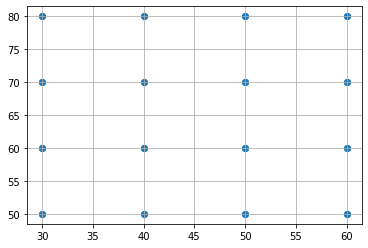

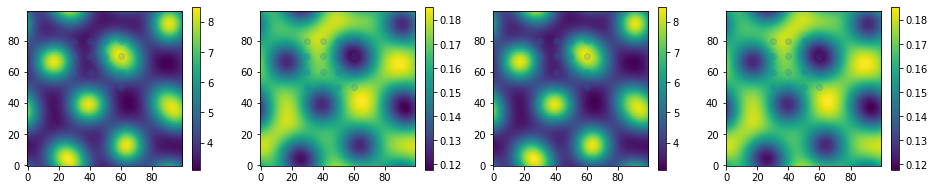

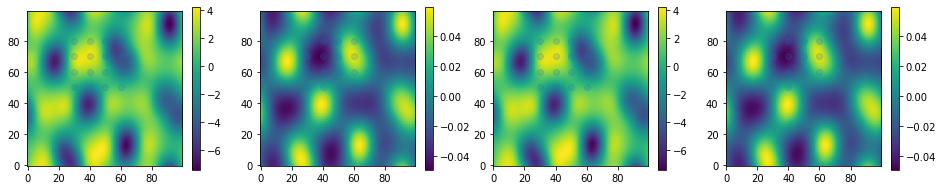

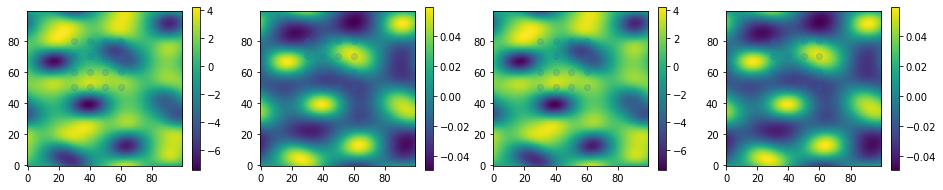

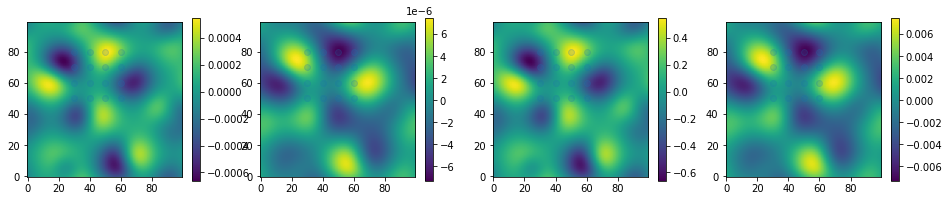

In [99]:
plt.scatter((x_size-1)*obs_X[:,0]/L, (x_size-1)*obs_X[:,1]/L)
plt.grid()
plt.show()

## Important Note:
##                Since in data the x is the first and y is the second indices,
##                x is changing in the outer arrays. So, we must transpose them on
##                ploting time
def plot_domain(d, scale_1=1.0, scale_2=1.0):
    _ = plt.figure(figsize=(16,4))
    plt.subplot(141)
    plt.imshow(d[0,:,:, -1].T, origin='lower')
    plt.colorbar(shrink=.75)
    plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
    plt.subplot(142)
    plt.imshow(d[1,:,:, -1].T, origin='lower')
    plt.colorbar(shrink=.75)
    plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
    plt.subplot(143)
    plt.imshow(scale_1*d[0,:,:, -1].T, origin='lower')
    plt.colorbar(shrink=.75)
    plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
    plt.subplot(144)
    plt.imshow(scale_2*d[1,:,:, -1].T, origin='lower')
    plt.colorbar(shrink=.75)
    plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
    plt.show()

plot_domain(data, scale_1=scales[0], scale_2=scales[1])
plot_domain(c_xx, scale_1=scales[2], scale_2=scales[5])
plot_domain(c_yy, scale_1=scales[3], scale_2=scales[6])
plot_domain(c_t, scale_1=scales[4], scale_2=scales[7])



In [100]:
#ds = TINN_Dataset(tf.float32, obs_X,  pde_X, pbc_X, diffs)
#ds = TINN_Dataset(tf.float32, obs_X,  pde_X, pbc_X)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, pbc_X, diffs_point)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, diffs_point)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, diffs_point)#, pbc_X)
#ds = TINN_Dataset(tf.float32, der_X, obs_X, pde_X)

# ds_der = TINN_Dataset(tf.float32, der_X)
# ds_der_1 = TINN_Dataset(tf.float32, obs_X, der_X_1)
# ds_test = TINN_Dataset(tf.float32, obs_test)
# ds_obs_der = TINN_Dataset(tf.float32, obs_der_X)
# ds = TINN_Dataset(tf.float32, obs_der_X, pde_X)


#ds_obs = TINN_Dataset(tf.float32, obs_X)
ds_obs = TINN_Dataset(tf.float32, obs_X, pde_X)

In [101]:
ds_obs.sizes

array([32, 32])

In [123]:
1024*8

8192

In [ ]:
#layers = [3, 1024, 1024, 1024, 8]
#layers = [3, 512, 512, 512, 512, 2]
#layers = [3, 128, 128, 128, 128, 128, 2]
#layers = [3, 32, 32, 32, 32, 8]
layers = [3, 2048, 2048, 8]

pinnKM = tu.NN(layers, lb, ub, dtype=tf.float32)
pde_resKM = Koch_Meinhard_output_as_Der(
                    dtype = pinnKM.dtype,
                    D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, simulation.Ds[0], dtype=pinnKM.dtype),
                    D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT,  simulation.Ds[1], dtype=pinnKM.dtype),
                    kappa_u=PDE_Parameter("kappa_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype, zero_lb=True),
                    #kappa_u=PDE_Parameter("kappa_u", Parameter_Type.CONSTANT, simulation.parameters["kappa_u"] ,dtype=pinnKM.dtype),
                    mu_u=PDE_Parameter("mu_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    #mu_u=PDE_Parameter("mu_u", Parameter_Type.CONSTANT, simulation.parameters["mu_u"],dtype=pinnKM.dtype),
                    rho_u=PDE_Parameter("rho_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    #rho_u=PDE_Parameter("rho_u", Parameter_Type.CONSTANT, simulation.parameters["rho_u"],dtype=pinnKM.dtype),                    
                    rho_v=PDE_Parameter("rho_v", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),                    
                    #rho_v=PDE_Parameter("rho_v", Parameter_Type.CONSTANT, simulation.parameters["rho_v"],dtype=pinnKM.dtype),                    
                    sigma_u=PDE_Parameter("sigma_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    #sigma_u=PDE_Parameter("sigma_u", Parameter_Type.CONSTANT, simulation.parameters["sigma_u"],dtype=pinnKM.dtype),
                    sigma_v=PDE_Parameter("sigma_v", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    #sigma_v=PDE_Parameter("sigma_v", Parameter_Type.CONSTANT, simulation.parameters["sigma_v"],dtype=pinnKM.dtype),

                    #                    dtype=pinnKM.dtype),
    outputs_scales = 1.0/scales,#[1, 1, 4, 4, 1/1000, 0.4, 0.4, 1/10000],
    regularise=False
    )
# pde_resKM = Brusselator(
#                     D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, simulation.Ds[0], dtype=pinnKM.dtype),
#                     D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT, simulation.Ds[1], dtype=pinnKM.dtype),                    
#                     A=PDE_Parameter("A", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
#                     B=PDE_Parameter("B", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype), 
#                    regularise=True,
#     )
#obs_loss = Observation_Loss(regularise=True, input_dim=2)
#obs_loss = Observation_Loss(layers=layers, 
#                           residual_ret_names=("u", "v", "u_xx", "u_yy", "u_t", "v_xx", "v_yy", "v_t"))

obs_loss = Scaled_Output_Loss(dtype = pinnKM.dtype,
                              layers=layers, 
                              scales=scales,
                              residual_ret_names=("u", "v", "u_xx", "u_yy", "u_t", "v_xx", "v_yy", "v_t"))
#pbc_loss = Periodic_Boundary_Condition(regularise=True)
#diff_loss_point = Diffusion_point_Loss(
#                            Ds = simulation.Ds,
#                            #input_dim =2,
#                            dtype = pinnKM.dtype)
#der_loss = All_Derivatives_Loss(dtype = pinnKM.dtype,
                            #Ds = simulation.Ds,
#                           )
#obs_der_loss = Observation_And_Derivatives_Loss(dtype = pinnKM.dtype,
#                            Ds = simulation.Ds,
#                           )
# diff_loss = Diffusion_Loss(ns = simulation.n,
#                            Ls = simulation.L,
#                            Ds = simulation.Ds,
#                            dtype = pinnKM.dtype)

#nzp_loss = Non_zero_params("Koch_Meinhard", [pde_resKM.sigma_u.tf_var, pde_resKM.sigma_v.tf_var])
#obs_X, pde_X)
modelKM = tu.TINN(pinnKM, 
                  #losses= [obs_loss, pde_resKM, pbc_loss, diff_loss_point], 
                  #losses= [obs_loss, pde_resKM, diff_loss_point], 
                  #losses= [obs_der_loss],#, pde_resKM],
                  #losses= [der_loss, obs_loss, pde_resKM], 
                  losses= [obs_loss, pde_resKM],
                  norm = L2(),# + L_Inf(),
                  #no_input_losses=[nzp_loss],
                  optimizer=keras.optimizers.Adam(learning_rate=5e-4),
                  alpha = 0.9, 
                  loss_penalty_power = 3,
                  print_precision=".12f")

In [127]:
relative_mean_denominators

array([2.66676209e+01, 2.48767911e-02, 5.58123082e+00, 4.40166448e+00,
       5.87262556e-02, 7.02052653e-04, 4.77832010e-04, 1.05590128e-05,
       1.00000000e+00, 1.00000000e+00])

In [ ]:
results_KM = modelKM.train(epochs = 10000+1,
                          batch_size = 245,
                          dataset = ds_obs,
                          print_interval=500,
                          stop_threshold = 1e-9,
                          sample_losses = True,              
                          sample_regularisations = False,
                          regularise=False,
                          regularise_interval=1,
                          relative_mean_denominators=relative_mean_denominators
                          )

modelKM.optimizer.lr.assign(1e-4)
results_KM2 = modelKM.train(epochs = 100000+1,
                          batch_size = 245,
                          dataset = ds_obs,
                          print_interval=1000,
                          stop_threshold = 1e-9,
                          sample_losses = True,              
                          sample_regularisations = False,
                          regularise=False,
                          regularise_interval=1,
                           relative_mean_denominators=relative_mean_denominators)


Start of epoch 0
total loss: 18.840455960482, total regularised loss: 6.977650165558
Observation_Loss -> 
(1)  u: 0.040926307440 (2)  v: 0.597139358521 (3)  u_xx: 0.545349359512 
(4)  u_yy: 0.627952337265 (5)  u_t: 0.822323918343 (6)  v_xx: 6.284994125366 
(7)  v_yy: 9.122806549072 (8)  v_t: 0.792406201363 
Loss_Koch_Meinhard -> 
(9)  res u: 0.002533929888 (10)  res v: 0.004025393631 
sigma_u: 1.43270 sigma_v: 0.39300 mu_u: 0.47494 rho_u: 1.47933 
rho_v: 0.55730 kappa_u: 0.26881 
Time taken: 0.05s

Start of epoch 500
total loss: 17.106249420438, total regularised loss: 6.969838142395
Observation_Loss -> 
(1)  u: 0.040904931724 (2)  v: 0.550774514675 (3)  u_xx: 0.545232653618 
(4)  u_yy: 0.627196013927 (5)  u_t: 0.817013025284 (6)  v_xx: 5.600160121918 
(7)  v_yy: 8.117882728577 (8)  v_t: 0.801360189915 
Loss_Koch_Meinhard -> 
(9)  res u: 0.002180283889 (10)  res v: 0.003544234205 
sigma_u: 1.43220 sigma_v: 0.36542 mu_u: 0.47283 rho_u: 1.48322 
rho_v: 0.52598 kappa_u: 0.25918 
Time tak


Start of epoch 6000
total loss: 1.471317386022, total regularised loss: 2.174015045166
Observation_Loss -> 
(1)  u: 0.010094414465 (2)  v: 0.217999711633 (3)  u_xx: 0.134134098887 
(4)  u_yy: 0.259662359953 (5)  u_t: 0.109507970512 (6)  v_xx: 0.099150337279 
(7)  v_yy: 0.232804149389 (8)  v_t: 0.406762421131 
Loss_Koch_Meinhard -> 
(9)  res u: 0.001192661235 (10)  res v: 0.000009301564 
sigma_u: 1.20788 sigma_v: 0.06567 mu_u: 0.58592 rho_u: 1.55172 
rho_v: 0.05940 kappa_u: 0.07999 
Time taken: 15.65s

Start of epoch 7000
total loss: 1.044060419081, total regularised loss: 1.873335003853
Observation_Loss -> 
(1)  u: 0.009063033387 (2)  v: 0.209485098720 (3)  u_xx: 0.111534401774 
(4)  u_yy: 0.226286992431 (5)  u_t: 0.107869565487 (6)  v_xx: 0.092179737985 
(7)  v_yy: 0.190309852362 (8)  v_t: 0.095927685499 
Loss_Koch_Meinhard -> 
(9)  res u: 0.001393957064 (10)  res v: 0.000010040309 
sigma_u: 1.18525 sigma_v: 0.06673 mu_u: 0.59773 rho_u: 1.55193 
rho_v: 0.05759 kappa_u: 0.07717 
Time 


Start of epoch 23000
total loss: 0.184919848049, total regularised loss: 0.055809404701
Observation_Loss -> 
(1)  u: 0.000295731297 (2)  v: 0.124218873680 (3)  u_xx: 0.002003549365 
(4)  u_yy: 0.007108750287 (5)  u_t: 0.027199838310 (6)  v_xx: 0.003227061126 
(7)  v_yy: 0.003126956522 (8)  v_t: 0.016980187967 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000757234870 (10)  res v: 0.000001665357 
sigma_u: 0.92876 sigma_v: 0.08456 mu_u: 0.70858 rho_u: 1.55157 
rho_v: 0.05026 kappa_u: 0.05156 
Time taken: 15.31s

Start of epoch 24000
total loss: 0.176259406609, total regularised loss: 0.045800037682
Observation_Loss -> 
(1)  u: 0.000256177154 (2)  v: 0.123081728816 (3)  u_xx: 0.001057185582 
(4)  u_yy: 0.006361824926 (5)  u_t: 0.023827245459 (6)  v_xx: 0.002521271352 
(7)  v_yy: 0.002685646527 (8)  v_t: 0.015867326409 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000600286934 (10)  res v: 0.000000714860 
sigma_u: 0.92089 sigma_v: 0.08499 mu_u: 0.71164 rho_u: 1.55086 
rho_v: 0.05003 kappa_u: 0.05117 
Tim

In [ ]:
'sigma_u': 1.0, 'sigma_v': 0.1 , 'mu_u': 1.0, 'rho_u': 1.0, 
'rho_v': 0.025, 'kappa_u': 0.0

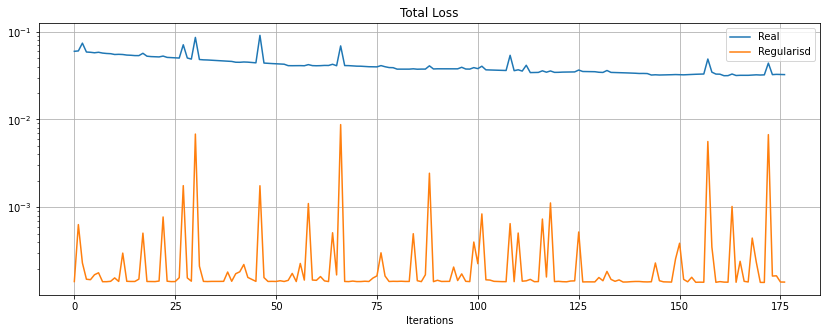

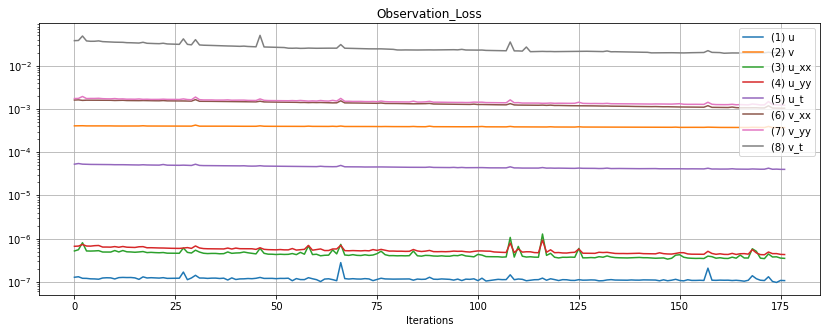

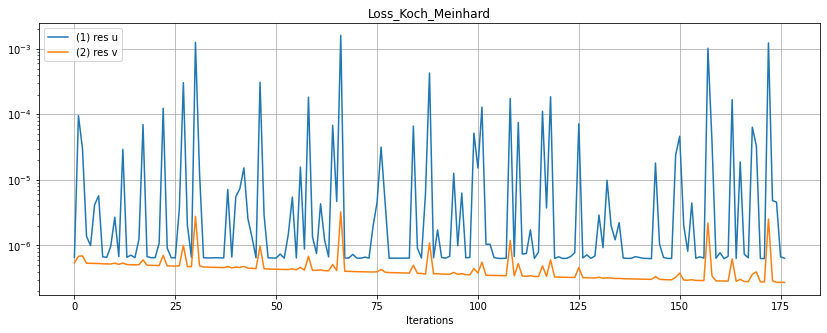

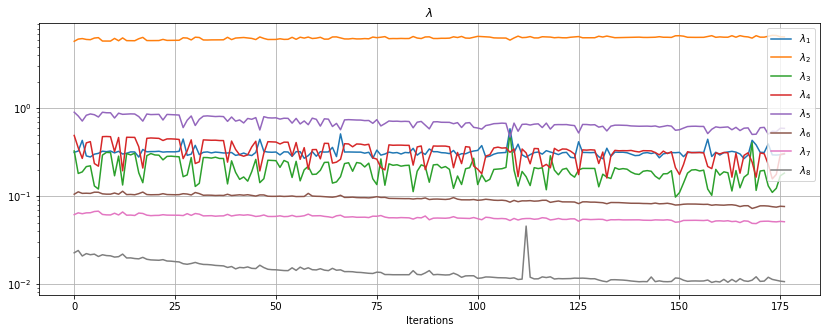

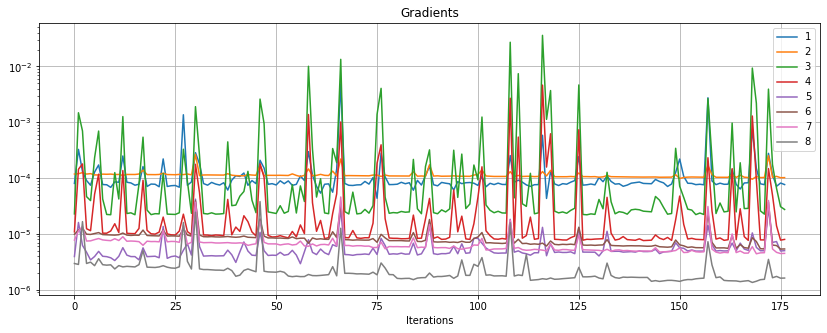

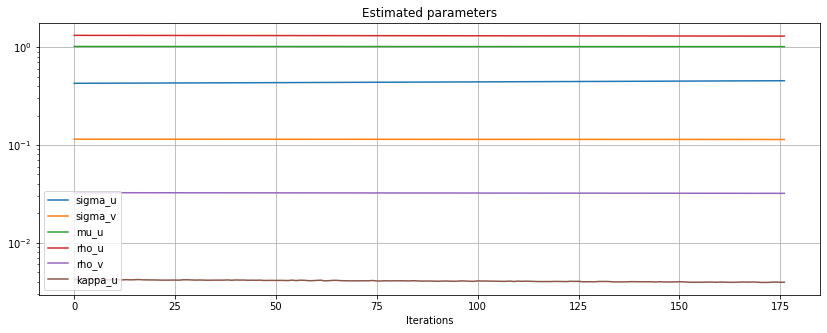

In [116]:
plot_result(merge_dict(results_KM, results_KM2), 
           modelKM, start=50000,skip=300, param_names=pde_resKM.parameter_names())

In [53]:
results_KM = modelKM.train(epochs = 3000+1,
                          batch_size = 245,
                          dataset = ds_obs,
                          print_interval=500,
                          stop_threshold = 1e-9,
                          sample_losses = True,              
                          sample_regularisations = False,
                          regularise=False,
                          regularise_interval=1,
                          relative_mean_denominators=relative_mean_denominators
                          )

modelKM.optimizer.lr.assign(1e-4)
results_KM2 = modelKM.train(epochs = 100000+1,
                          batch_size = 245,
                          dataset = ds_obs,
                          print_interval=1000,
                          stop_threshold = 1e-9,
                          sample_losses = True,              
                          sample_regularisations = False,
                          regularise=False,
                          regularise_interval=1,
                           relative_mean_denominators=relative_mean_denominators)


Start of epoch 0
total loss: 234.571509599686, total regularised loss: 39.017620086670
Observation_Loss -> 
(1)  u: 0.993681252003 (2)  v: 0.473658472300 (3)  u_xx: 1.011317729950 
(4)  u_yy: 1.016306400299 (5)  u_t: 1.229304432869 (6)  v_xx: 196.705963134766 
(7)  v_yy: 25.659837722778 (8)  v_t: 5.320726871490 
Loss_Koch_Meinhard -> 
(9)  res u: 1.008389472961 (10)  res v: 1.152323007584 
sigma_u: 0.99950 sigma_v: 0.99950 mu_u: 0.99950 rho_u: 0.99950 
rho_v: 1.00050 kappa_u: 0.99951 
Time taken: 2.03s

Start of epoch 500
total loss: 116.191109627485, total regularised loss: 4.905129432678
Observation_Loss -> 
(1)  u: 0.029450673610 (2)  v: 34.864700317383 (3)  u_xx: 0.198002055287 
(4)  u_yy: 0.383328944445 (5)  u_t: 0.408879458904 (6)  v_xx: 31.766475677490 
(7)  v_yy: 47.184501647949 (8)  v_t: 0.965606987476 
Loss_Koch_Meinhard -> 
(9)  res u: 0.366203844547 (10)  res v: 0.023964317515 
sigma_u: 1.19175 sigma_v: 1.02240 mu_u: 0.76832 rho_u: 1.23073 
rho_v: 0.80656 kappa_u: 0.68741 


Start of epoch 10000
total loss: 0.097619396595, total regularised loss: 0.002424727427
Observation_Loss -> 
(1)  u: 0.000000060395 (2)  v: 0.096744529903 (3)  u_xx: 0.000000226485 
(4)  u_yy: 0.000000142114 (5)  u_t: 0.000062544976 (6)  v_xx: 0.000205680175 
(7)  v_yy: 0.000332083931 (8)  v_t: 0.000263852358 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000010024263 (10)  res v: 0.000000254705 
sigma_u: 1.01096 sigma_v: 0.08469 mu_u: 0.75234 rho_u: 1.45468 
rho_v: 0.04492 kappa_u: 0.03566 
Time taken: 20.39s

Start of epoch 11000
total loss: 0.076983139019, total regularised loss: 0.001910358435
Observation_Loss -> 
(1)  u: 0.000000046153 (2)  v: 0.076204054058 (3)  u_xx: 0.000000204216 
(4)  u_yy: 0.000000124036 (5)  u_t: 0.000059520022 (6)  v_xx: 0.000177653332 
(7)  v_yy: 0.000286471710 (8)  v_t: 0.000247354066 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000007488879 (10)  res v: 0.000000222572 
sigma_u: 0.96263 sigma_v: 0.08858 mu_u: 0.78277 rho_u: 1.43979 
rho_v: 0.04330 kappa_u: 0.03097 
Tim


Start of epoch 27000
total loss: 0.005593490555, total regularised loss: 0.000132842804
Observation_Loss -> 
(1)  u: 0.000000020033 (2)  v: 0.005127202719 (3)  u_xx: 0.000000114525 
(4)  u_yy: 0.000000057030 (5)  u_t: 0.000039769071 (6)  v_xx: 0.000102904531 
(7)  v_yy: 0.000167480350 (8)  v_t: 0.000154723515 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000001109138 (10)  res v: 0.000000109732 
sigma_u: 0.62344 sigma_v: 0.10793 mu_u: 0.96385 rho_u: 1.33311 
rho_v: 0.03430 kappa_u: 0.00913 
Time taken: 18.64s

Start of epoch 28000
total loss: 0.004985276672, total regularised loss: 0.000122260084
Observation_Loss -> 
(1)  u: 0.000000020591 (2)  v: 0.004487886559 (3)  u_xx: 0.000000113608 
(4)  u_yy: 0.000000065655 (5)  u_t: 0.000039251947 (6)  v_xx: 0.000110575296 
(7)  v_yy: 0.000177245864 (8)  v_t: 0.000163613542 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000006362701 (10)  res v: 0.000000140787 
sigma_u: 0.61532 sigma_v: 0.10831 mu_u: 0.96798 rho_u: 1.33024 
rho_v: 0.03411 kappa_u: 0.00874 
Tim


Start of epoch 44000
total loss: 0.001270965856, total regularised loss: 0.000025130210
Observation_Loss -> 
(1)  u: 0.000000015651 (2)  v: 0.000869277865 (3)  u_xx: 0.000000087924 
(4)  u_yy: 0.000000049220 (5)  u_t: 0.000033618751 (6)  v_xx: 0.000099566474 
(7)  v_yy: 0.000139065742 (8)  v_t: 0.000129150547 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000052332 (10)  res v: 0.000000081263 
sigma_u: 0.54575 sigma_v: 0.11149 mu_u: 1.00355 rho_u: 1.30395 
rho_v: 0.03251 kappa_u: 0.00547 
Time taken: 20.22s

Start of epoch 45000
total loss: 0.001210681202, total regularised loss: 0.000023662535
Observation_Loss -> 
(1)  u: 0.000000015497 (2)  v: 0.000811705657 (3)  u_xx: 0.000000086581 
(4)  u_yy: 0.000000049002 (5)  u_t: 0.000033385637 (6)  v_xx: 0.000099548495 
(7)  v_yy: 0.000137775205 (8)  v_t: 0.000127988897 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000046072 (10)  res v: 0.000000080161 
sigma_u: 0.54363 sigma_v: 0.11159 mu_u: 1.00465 rho_u: 1.30305 
rho_v: 0.03246 kappa_u: 0.00538 
Tim


Start of epoch 61000
total loss: 0.000802734747, total regularised loss: 0.000014396306
Observation_Loss -> 
(1)  u: 0.000000012981 (2)  v: 0.000433530367 (3)  u_xx: 0.000000073858 
(4)  u_yy: 0.000000045433 (5)  u_t: 0.000030452235 (6)  v_xx: 0.000099347861 
(7)  v_yy: 0.000124404512 (8)  v_t: 0.000114252565 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000545183 (10)  res v: 0.000000069720 
sigma_u: 0.52486 sigma_v: 0.11242 mu_u: 1.01469 rho_u: 1.29393 
rho_v: 0.03198 kappa_u: 0.00448 
Time taken: 20.16s

Start of epoch 62000
total loss: 0.000790475128, total regularised loss: 0.000013629171
Observation_Loss -> 
(1)  u: 0.000000012940 (2)  v: 0.000424080063 (3)  u_xx: 0.000000072094 
(4)  u_yy: 0.000000044805 (5)  u_t: 0.000030299221 (6)  v_xx: 0.000099058081 
(7)  v_yy: 0.000123668418 (8)  v_t: 0.000113132206 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000040315 (10)  res v: 0.000000066979 
sigma_u: 0.52430 sigma_v: 0.11246 mu_u: 1.01501 rho_u: 1.29358 
rho_v: 0.03196 kappa_u: 0.00444 
Tim


Start of epoch 78000
total loss: 0.000716136343, total regularised loss: 0.000013520286
Observation_Loss -> 
(1)  u: 0.000000011404 (2)  v: 0.000367717235 (3)  u_xx: 0.000000063102 
(4)  u_yy: 0.000000043862 (5)  u_t: 0.000028241158 (6)  v_xx: 0.000098490600 
(7)  v_yy: 0.000117424941 (8)  v_t: 0.000102512735 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000001569895 (10)  res v: 0.000000061414 
sigma_u: 0.51979 sigma_v: 0.11266 mu_u: 1.01790 rho_u: 1.28946 
rho_v: 0.03179 kappa_u: 0.00416 
Time taken: 20.20s

Start of epoch 79000
total loss: 0.000710925785, total regularised loss: 0.000011911237
Observation_Loss -> 
(1)  u: 0.000000011182 (2)  v: 0.000366367749 (3)  u_xx: 0.000000061942 
(4)  u_yy: 0.000000042114 (5)  u_t: 0.000028127424 (6)  v_xx: 0.000097838813 
(7)  v_yy: 0.000116522227 (8)  v_t: 0.000101870173 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000026228 (10)  res v: 0.000000057939 
sigma_u: 0.51971 sigma_v: 0.11268 mu_u: 1.01798 rho_u: 1.28928 
rho_v: 0.03178 kappa_u: 0.00414 
Tim


Start of epoch 95000
total loss: 0.000685488642, total regularised loss: 0.000011430220
Observation_Loss -> 
(1)  u: 0.000000009943 (2)  v: 0.000353029609 (3)  u_xx: 0.000000055027 
(4)  u_yy: 0.000000040490 (5)  u_t: 0.000026466305 (6)  v_xx: 0.000097382828 
(7)  v_yy: 0.000113960617 (8)  v_t: 0.000094423136 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000068077 (10)  res v: 0.000000052599 
sigma_u: 0.51965 sigma_v: 0.11270 mu_u: 1.01866 rho_u: 1.28674 
rho_v: 0.03170 kappa_u: 0.00403 
Time taken: 20.29s

Start of epoch 96000
total loss: 0.000684182508, total regularised loss: 0.000011356376
Observation_Loss -> 
(1)  u: 0.000000009907 (2)  v: 0.000352236588 (3)  u_xx: 0.000000054434 
(4)  u_yy: 0.000000040361 (5)  u_t: 0.000026369778 (6)  v_xx: 0.000097434538 
(7)  v_yy: 0.000114032271 (8)  v_t: 0.000093927141 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000025594 (10)  res v: 0.000000051938 
sigma_u: 0.51970 sigma_v: 0.11270 mu_u: 1.01867 rho_u: 1.28660 
rho_v: 0.03170 kappa_u: 0.00403 
Tim

In [59]:
modelKM.optimizer.lr.assign(5e-5)
results_KM3 = modelKM.train(epochs = 100000+1,
                          batch_size = 245,
                          dataset = ds_obs,
                          print_interval=1000,
                          stop_threshold = 1e-6,
                          sample_losses = True,              
                          sample_regularisations = False,
                          regularise=False,
                          regularise_interval=1,
                           relative_mean_denominators=relative_mean_denominators)


Start of epoch 0
total loss: 0.000681507665, total regularised loss: 0.000011320837
Observation_Loss -> 
(1)  u: 0.000000009835 (2)  v: 0.000351259689 (3)  u_xx: 0.000000052598 
(4)  u_yy: 0.000000040217 (5)  u_t: 0.000025989741 (6)  v_xx: 0.000097302560 
(7)  v_yy: 0.000114492083 (8)  v_t: 0.000092257862 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000052713 (10)  res v: 0.000000050345 
sigma_u: 0.51996 sigma_v: 0.11269 mu_u: 1.01870 rho_u: 1.28607 
rho_v: 0.03169 kappa_u: 0.00402 
Time taken: 0.06s

Start of epoch 1000
total loss: 0.000676411368, total regularised loss: 0.000011168592
Observation_Loss -> 
(1)  u: 0.000000009608 (2)  v: 0.000346732180 (3)  u_xx: 0.000000052633 
(4)  u_yy: 0.000000039899 (5)  u_t: 0.000025934150 (6)  v_xx: 0.000097161996 
(7)  v_yy: 0.000114023722 (8)  v_t: 0.000092383052 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000023479 (10)  res v: 0.000000050667 
sigma_u: 0.51994 sigma_v: 0.11270 mu_u: 1.01876 rho_u: 1.28601 
rho_v: 0.03169 kappa_u: 0.00396 
Time take


Start of epoch 17000
total loss: 0.000700309936, total regularised loss: 0.000023189836
Observation_Loss -> 
(1)  u: 0.000000009459 (2)  v: 0.000334410812 (3)  u_xx: 0.000000057522 
(4)  u_yy: 0.000000057201 (5)  u_t: 0.000024530775 (6)  v_xx: 0.000107016160 
(7)  v_yy: 0.000129433887 (8)  v_t: 0.000092423601 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000012271736 (10)  res v: 0.000000098794 
sigma_u: 0.51982 sigma_v: 0.11276 mu_u: 1.02040 rho_u: 1.28377 
rho_v: 0.03159 kappa_u: 0.00381 
Time taken: 20.28s

Start of epoch 18000
total loss: 0.000669356627, total regularised loss: 0.000014611954
Observation_Loss -> 
(1)  u: 0.000000009102 (2)  v: 0.000333499949 (3)  u_xx: 0.000000048002 
(4)  u_yy: 0.000000042757 (5)  u_t: 0.000024399553 (6)  v_xx: 0.000097456985 
(7)  v_yy: 0.000120001278 (8)  v_t: 0.000089935937 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000003906982 (10)  res v: 0.000000056103 
sigma_u: 0.51990 sigma_v: 0.11276 mu_u: 1.02045 rho_u: 1.28365 
rho_v: 0.03159 kappa_u: 0.00381 
Tim


Start of epoch 34000
total loss: 0.000718776679, total regularised loss: 0.000047495141
Observation_Loss -> 
(1)  u: 0.000000008931 (2)  v: 0.000334622338 (3)  u_xx: 0.000000058529 
(4)  u_yy: 0.000000077907 (5)  u_t: 0.000023260254 (6)  v_xx: 0.000103179533 
(7)  v_yy: 0.000128997606 (8)  v_t: 0.000091905611 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000036546320 (10)  res v: 0.000000119634 
sigma_u: 0.52181 sigma_v: 0.11274 mu_u: 1.02107 rho_u: 1.28209 
rho_v: 0.03153 kappa_u: 0.00375 
Time taken: 20.29s

Start of epoch 35000
total loss: 0.000657511211, total regularised loss: 0.000010462849
Observation_Loss -> 
(1)  u: 0.000000007935 (2)  v: 0.000330164708 (3)  u_xx: 0.000000042615 
(4)  u_yy: 0.000000037270 (5)  u_t: 0.000022942468 (6)  v_xx: 0.000095442214 
(7)  v_yy: 0.000120883371 (8)  v_t: 0.000087919623 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000023371 (10)  res v: 0.000000047619 
sigma_u: 0.52196 sigma_v: 0.11274 mu_u: 1.02110 rho_u: 1.28201 
rho_v: 0.03153 kappa_u: 0.00375 
Tim


Start of epoch 51000
total loss: 0.000654015651, total regularised loss: 0.000010275940
Observation_Loss -> 
(1)  u: 0.000000007306 (2)  v: 0.000327261660 (3)  u_xx: 0.000000039698 
(4)  u_yy: 0.000000036589 (5)  u_t: 0.000021705702 (6)  v_xx: 0.000095091491 
(7)  v_yy: 0.000123205755 (8)  v_t: 0.000086601955 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000018877 (10)  res v: 0.000000046625 
sigma_u: 0.52448 sigma_v: 0.11269 mu_u: 1.02137 rho_u: 1.28069 
rho_v: 0.03149 kappa_u: 0.00371 
Time taken: 20.14s

Start of epoch 52000
total loss: 0.000654058918, total regularised loss: 0.000010268925
Observation_Loss -> 
(1)  u: 0.000000007306 (2)  v: 0.000327158486 (3)  u_xx: 0.000000039469 
(4)  u_yy: 0.000000036494 (5)  u_t: 0.000021629636 (6)  v_xx: 0.000095088973 
(7)  v_yy: 0.000123584221 (8)  v_t: 0.000086447159 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000020815 (10)  res v: 0.000000046395 
sigma_u: 0.52464 sigma_v: 0.11268 mu_u: 1.02139 rho_u: 1.28061 
rho_v: 0.03149 kappa_u: 0.00372 
Tim


Start of epoch 68000
total loss: 0.000650495465, total regularised loss: 0.000010098664
Observation_Loss -> 
(1)  u: 0.000000006820 (2)  v: 0.000324363587 (3)  u_xx: 0.000000037004 
(4)  u_yy: 0.000000035902 (5)  u_t: 0.000020471145 (6)  v_xx: 0.000094812502 
(7)  v_yy: 0.000125505889 (8)  v_t: 0.000085198233 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000018867 (10)  res v: 0.000000045569 
sigma_u: 0.52735 sigma_v: 0.11262 mu_u: 1.02158 rho_u: 1.27936 
rho_v: 0.03145 kappa_u: 0.00369 
Time taken: 20.32s

Start of epoch 69000
total loss: 0.000650527441, total regularised loss: 0.000010489831
Observation_Loss -> 
(1)  u: 0.000000006756 (2)  v: 0.000324470369 (3)  u_xx: 0.000000037234 
(4)  u_yy: 0.000000036574 (5)  u_t: 0.000020403650 (6)  v_xx: 0.000094734110 
(7)  v_yy: 0.000125064005 (8)  v_t: 0.000085320273 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000407577 (10)  res v: 0.000000046928 
sigma_u: 0.52752 sigma_v: 0.11262 mu_u: 1.02159 rho_u: 1.27929 
rho_v: 0.03145 kappa_u: 0.00369 
Tim


Start of epoch 85000
total loss: 0.000646514853, total regularised loss: 0.000009930493
Observation_Loss -> 
(1)  u: 0.000000006397 (2)  v: 0.000321553904 (3)  u_xx: 0.000000034771 
(4)  u_yy: 0.000000035260 (5)  u_t: 0.000019311199 (6)  v_xx: 0.000094451898 
(7)  v_yy: 0.000127277468 (8)  v_t: 0.000083782244 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000017105 (10)  res v: 0.000000044630 
sigma_u: 0.53030 sigma_v: 0.11256 mu_u: 1.02176 rho_u: 1.27807 
rho_v: 0.03142 kappa_u: 0.00367 
Time taken: 20.19s

Start of epoch 86000
total loss: 0.000647208002, total regularised loss: 0.000010149657
Observation_Loss -> 
(1)  u: 0.000000006438 (2)  v: 0.000320613821 (3)  u_xx: 0.000000034816 
(4)  u_yy: 0.000000035226 (5)  u_t: 0.000019260076 (6)  v_xx: 0.000094534022 
(7)  v_yy: 0.000128451997 (8)  v_t: 0.000083966348 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000259473 (10)  res v: 0.000000045815 
sigma_u: 0.53047 sigma_v: 0.11256 mu_u: 1.02177 rho_u: 1.27800 
rho_v: 0.03141 kappa_u: 0.00367 
Tim

In [60]:
results_KM4 = modelKM.train(epochs = 400000+1,
                          batch_size = 245,
                          dataset = ds_obs,
                          print_interval=10000,
                          stop_threshold = 1e-6,
                          sample_losses = True,              
                          sample_regularisations = False,
                          regularise=False,
                          regularise_interval=1,
                           relative_mean_denominators=relative_mean_denominators)


Start of epoch 0
total loss: 0.000641431121, total regularised loss: 0.000009803496
Observation_Loss -> 
(1)  u: 0.000000006000 (2)  v: 0.000319039857 (3)  u_xx: 0.000000033513 
(4)  u_yy: 0.000000035477 (5)  u_t: 0.000018342185 (6)  v_xx: 0.000093915980 
(7)  v_yy: 0.000127255131 (8)  v_t: 0.000082730665 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000027664 (10)  res v: 0.000000044674 
sigma_u: 0.53291 sigma_v: 0.11250 mu_u: 1.02192 rho_u: 1.27693 
rho_v: 0.03138 kappa_u: 0.00365 
Time taken: 0.06s

Start of epoch 10000
total loss: 0.000643967538, total regularised loss: 0.000011270972
Observation_Loss -> 
(1)  u: 0.000000005969 (2)  v: 0.000318494276 (3)  u_xx: 0.000000032438 
(4)  u_yy: 0.000000035858 (5)  u_t: 0.000017766017 (6)  v_xx: 0.000093848204 
(7)  v_yy: 0.000130923130 (8)  v_t: 0.000081269434 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000001547495 (10)  res v: 0.000000044721 
sigma_u: 0.53465 sigma_v: 0.11246 mu_u: 1.02202 rho_u: 1.27617 
rho_v: 0.03136 kappa_u: 0.00365 
Time tak


Start of epoch 170000
total loss: 0.000572375589, total regularised loss: 0.000008429621
Observation_Loss -> 
(1)  u: 0.000000003997 (2)  v: 0.000291506003 (3)  u_xx: 0.000000021426 
(4)  u_yy: 0.000000029660 (5)  u_t: 0.000009909961 (6)  v_xx: 0.000080984333 
(7)  v_yy: 0.000131877736 (8)  v_t: 0.000057984431 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000019754 (10)  res v: 0.000000038322 
sigma_u: 0.56259 sigma_v: 0.11183 mu_u: 1.02357 rho_u: 1.26408 
rho_v: 0.03103 kappa_u: 0.00346 
Time taken: 201.34s

Start of epoch 180000
total loss: 0.000589837282, total regularised loss: 0.000016911312
Observation_Loss -> 
(1)  u: 0.000000004531 (2)  v: 0.000288579176 (3)  u_xx: 0.000000028469 
(4)  u_yy: 0.000000046731 (5)  u_t: 0.000009670774 (6)  v_xx: 0.000083412109 
(7)  v_yy: 0.000143717087 (8)  v_t: 0.000055885550 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000008439310 (10)  res v: 0.000000053499 
sigma_u: 0.56433 sigma_v: 0.11179 mu_u: 1.02366 rho_u: 1.26332 
rho_v: 0.03101 kappa_u: 0.00344 



Start of epoch 340000
total loss: 0.000505113548, total regularised loss: 0.000011221880
Observation_Loss -> 
(1)  u: 0.000000003455 (2)  v: 0.000262248970 (3)  u_xx: 0.000000021134 
(4)  u_yy: 0.000000023624 (5)  u_t: 0.000005842757 (6)  v_xx: 0.000060464135 
(7)  v_yy: 0.000134946487 (8)  v_t: 0.000037668920 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000003821855 (10)  res v: 0.000000072219 
sigma_u: 0.59219 sigma_v: 0.11117 mu_u: 1.02516 rho_u: 1.25125 
rho_v: 0.03068 kappa_u: 0.00326 
Time taken: 181.40s

Start of epoch 350000
total loss: 0.000489493413, total regularised loss: 0.000016098824
Observation_Loss -> 
(1)  u: 0.000000003523 (2)  v: 0.000260199275 (3)  u_xx: 0.000000021399 
(4)  u_yy: 0.000000025753 (5)  u_t: 0.000005755359 (6)  v_xx: 0.000053947402 
(7)  v_yy: 0.000122684753 (8)  v_t: 0.000038031434 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000008766350 (10)  res v: 0.000000058181 
sigma_u: 0.59392 sigma_v: 0.11113 mu_u: 1.02525 rho_u: 1.25049 
rho_v: 0.03066 kappa_u: 0.00326 


In [65]:
results_KM5 = modelKM.train(epochs = 200000+1,
                          batch_size = 245,
                          dataset = ds_obs,
                          print_interval=10000,
                          stop_threshold = 1e-6,
                          sample_losses = True,              
                          sample_regularisations = False,
                          regularise=False,
                          regularise_interval=1,
                           relative_mean_denominators=relative_mean_denominators)


Start of epoch 0
total loss: 0.000465138663, total regularised loss: 0.000007051146
Observation_Loss -> 
(1)  u: 0.000000002601 (2)  v: 0.000255494175 (3)  u_xx: 0.000000011800 
(4)  u_yy: 0.000000017642 (5)  u_t: 0.000005001049 (6)  v_xx: 0.000047417721 
(7)  v_yy: 0.000124076352 (8)  v_t: 0.000033056094 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000021128 (10)  res v: 0.000000040100 
sigma_u: 0.60253 sigma_v: 0.11093 mu_u: 1.02570 rho_u: 1.24673 
rho_v: 0.03055 kappa_u: 0.00320 
Time taken: 0.08s

Start of epoch 10000
total loss: 0.000465629675, total regularised loss: 0.000007644757
Observation_Loss -> 
(1)  u: 0.000000002588 (2)  v: 0.000254606333 (3)  u_xx: 0.000000011772 
(4)  u_yy: 0.000000017734 (5)  u_t: 0.000004892401 (6)  v_xx: 0.000046468187 
(7)  v_yy: 0.000124728642 (8)  v_t: 0.000034219498 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000641765 (10)  res v: 0.000000040743 
sigma_u: 0.60426 sigma_v: 0.11089 mu_u: 1.02579 rho_u: 1.24598 
rho_v: 0.03053 kappa_u: 0.00319 
Time tak


Start of epoch 170000
total loss: 0.000416574325, total regularised loss: 0.000011046306
Observation_Loss -> 
(1)  u: 0.000000002230 (2)  v: 0.000230812802 (3)  u_xx: 0.000000010655 
(4)  u_yy: 0.000000016770 (5)  u_t: 0.000003691678 (6)  v_xx: 0.000035387540 
(7)  v_yy: 0.000116053277 (8)  v_t: 0.000025812071 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000004737426 (10)  res v: 0.000000049887 
sigma_u: 0.63181 sigma_v: 0.11027 mu_u: 1.02721 rho_u: 1.23397 
rho_v: 0.03020 kappa_u: 0.00301 
Time taken: 198.74s

Start of epoch 180000
total loss: 0.000406395504, total regularised loss: 0.000006200106
Observation_Loss -> 
(1)  u: 0.000000001979 (2)  v: 0.000228493009 (3)  u_xx: 0.000000008459 
(4)  u_yy: 0.000000010727 (5)  u_t: 0.000003574728 (6)  v_xx: 0.000034061042 
(7)  v_yy: 0.000115029565 (8)  v_t: 0.000025162653 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000015445 (10)  res v: 0.000000037907 
sigma_u: 0.63353 sigma_v: 0.11024 mu_u: 1.02730 rho_u: 1.23322 
rho_v: 0.03019 kappa_u: 0.00299 


In [66]:

print(pde_resKM.trainables_str())

sigma_u: 0.63696 sigma_v: 0.11016 mu_u: 1.02746 rho_u: 1.23172 
rho_v: 0.03015 kappa_u: 0.00297 


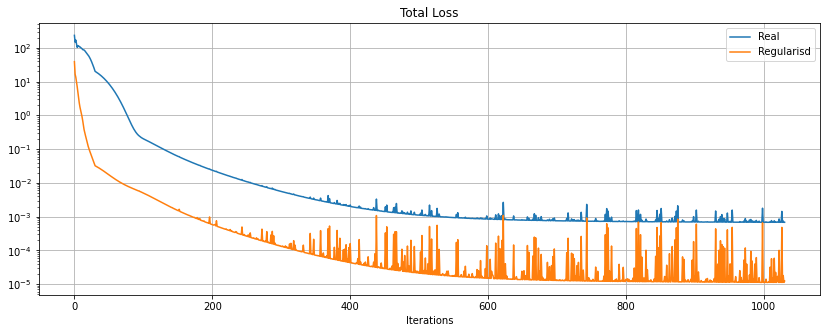

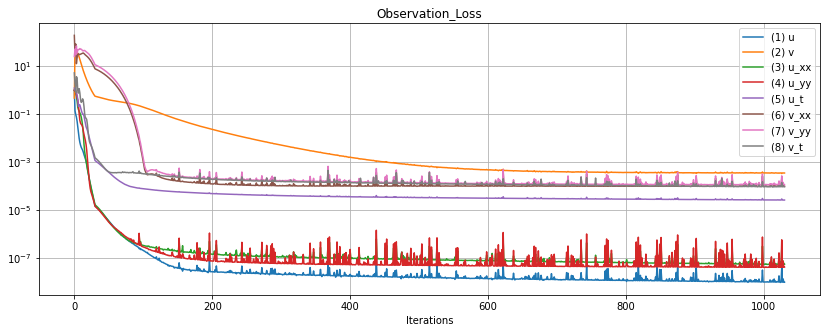

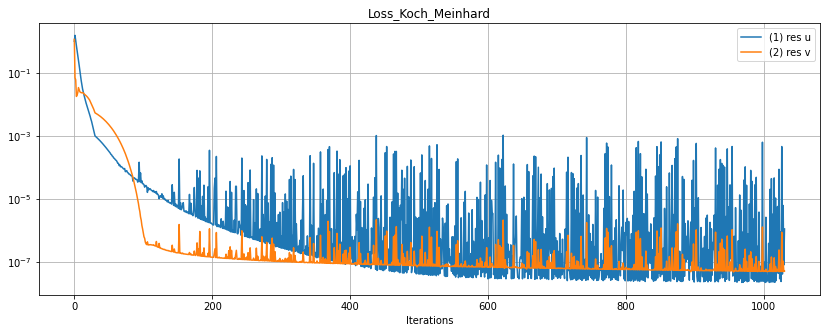

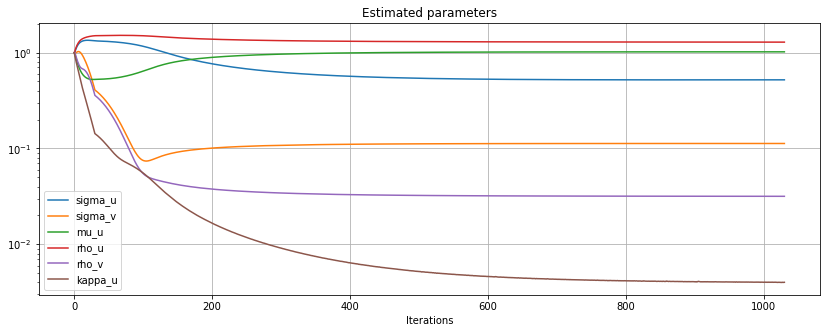

In [54]:
plot_result(merge_dict(results_KM, results_KM2), 
           modelKM, start=0,skip=100, param_names=pde_resKM.parameter_names())

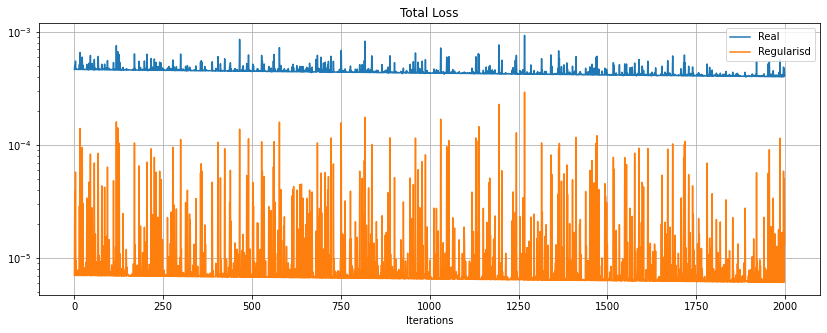

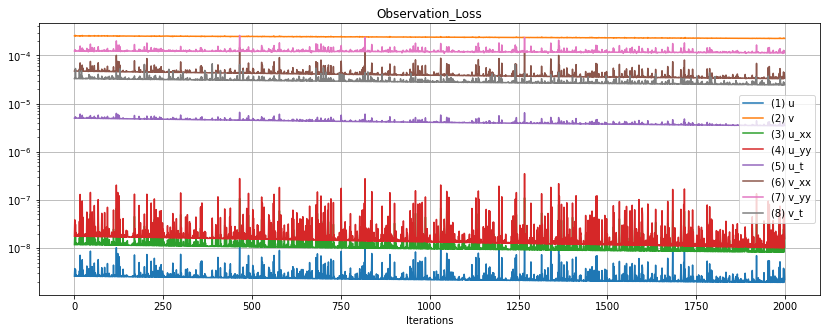

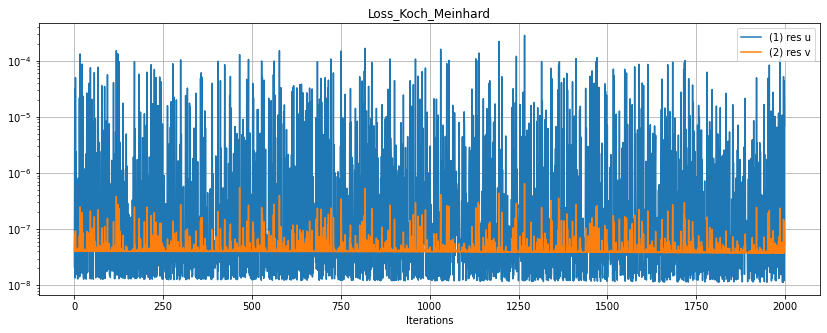

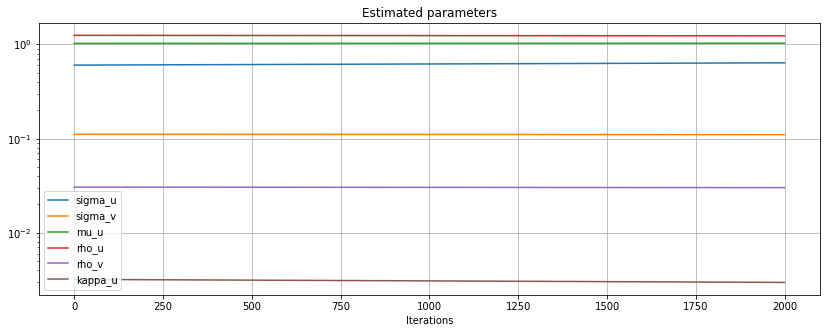

In [67]:
plot_result(merge_dict(results_KM5), 
           modelKM, start=0,skip=100, param_names=pde_resKM.parameter_names())

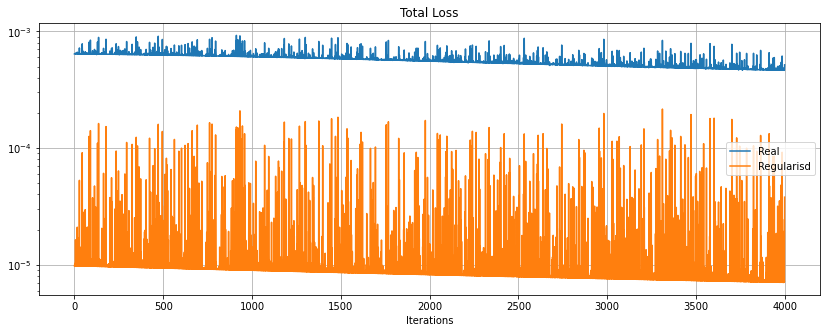

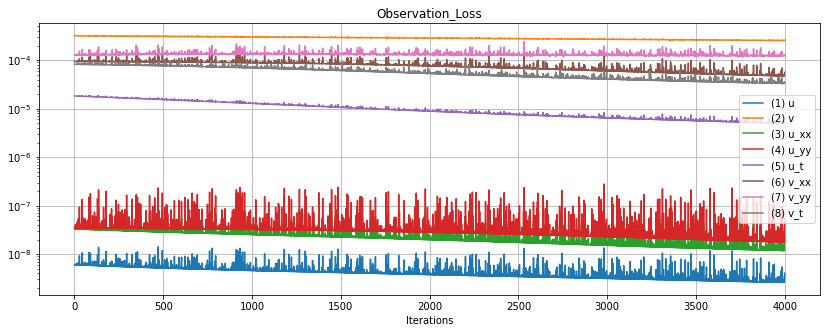

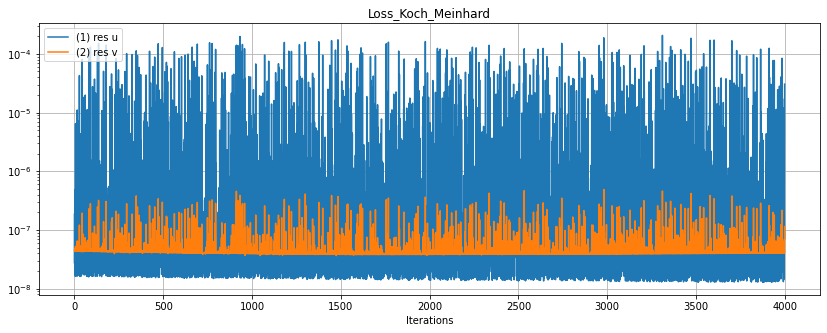

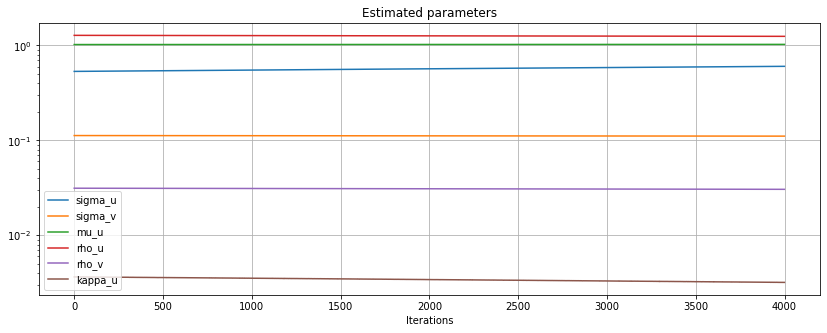

In [63]:
plot_result(merge_dict(results_KM4), 
           modelKM, start=0,skip=100, param_names=pde_resKM.parameter_names())

In [24]:
modelKM = tu.TINN.restore(".", "patch_points_parameter_estimation_derivatives_outputs_100000", ds_obs)
pinnKM = modelKM.pinn
obs_loss = modelKM.losses[0]
pde_resKM = modelKM.losses[1]

2022-12-19 20:46:19.243793: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-12-19 20:46:19.748658: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


In [56]:
def norm_params2(result, simulation):
    #D_u = pde_resKM.D_u.get_value(test_d)
    #D_v = pde_resKM.D_v.get_value(test_d)
    sigma_u = result["sigma_u"] if "sigma_u" in result.keys() else simulation.parameters["sigma_u"]
    sigma_v =  result["sigma_v"] if "sigma_v" in result.keys() else simulation.parameters["sigma_v"]
    mu_u = result["mu_u"] if "mu_u" in result.keys() else simulation.parameters["mu_u"]
    rho_u = result["rho_u"] if "rho_u" in result.keys() else simulation.parameters["rho_u"]
    rho_v = result["rho_v"] if "rho_v" in result.keys() else simulation.parameters["rho_v"]
    kappa_u = result["kappa_u"] if "kappa_u" in result.keys() else simulation.parameters["kappa_u"]
    
    sigma_u2 = simulation.parameters["sigma_u"]
    sigma_v2 = simulation.parameters["sigma_v"]
    mu_u2 = simulation.parameters["mu_u"]
    rho_u2 = simulation.parameters["rho_u"]
    rho_v2 = simulation.parameters["rho_v"]
    kappa_u2 = simulation.parameters["kappa_u"]
    
    return ((sigma_u-sigma_u2)**2 + 
            (sigma_v-sigma_v2)**2 +
            (mu_u-mu_u2)**2 +
            (rho_u-rho_u2)**2 + 
            (rho_v-rho_v2)**2 +
            (kappa_u-kappa_u2)**2
           )
        

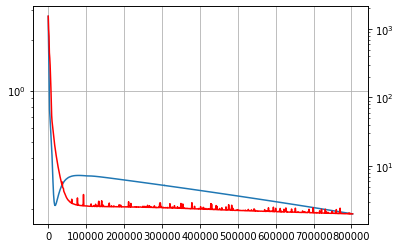

In [71]:
def relative(ax, d, step=1):    
    xs = np.arange(0, d['loss_total'].shape[0])
    ax.plot(xs[::step], 100*np.sqrt(d['loss_total'][::step,]), c='r')
    
def relative2(ax, d, index, step=1):    
    xs = np.arange(0, d['Observation_Loss_values'][::, index].shape[0])
    ax.plot(xs[::step], 100*np.sqrt(d['Observation_Loss_values'][::step, index]))
    
ax = plt.gca()
ax.plot(norm_params2(merge_dict(results_KM, results_KM2, results_KM3, results_KM4, results_KM5), simulation))
plt.yscale('log')
plt.grid()
ax2 = ax.twinx()
relative(ax2, merge_dict(results_KM, results_KM2, results_KM3, results_KM4, results_KM5), 1000)
#relative2(ax2, merge_dict(results_KM, results_KM2), 0, 1000)
#relative2(ax2, merge_dict(results_KM, results_KM2), 1, 1000)
plt.yscale('log')
plt.show()

In [40]:
test_d = obs_X[:,:3].astype(np.float32)

In [41]:
r = pde_resKM.residual(pinnKM, test_d)
l2 = L2()

print([np.mean(i.numpy()**2) for i in r ])
print(l2.reduce_norm(r).numpy())
print(np.sqrt(l2.reduce_norm(r).numpy()))

[6.4919004e-09, 1.4064821e-07]
[6.4919004e-09 1.4064824e-07]
[8.057233e-05 3.750310e-04]


In [42]:
outputs =  pinnKM.net(test_d)
#u_xx = outputs[:,0]
#u,  u_xx = (outputs[:,0], outputs[:,1])
#u, v, u_xx = (outputs[:,0], outputs[:,1], outputs[:,2])
#u, v, u_xx, v_xx = (outputs[:,0], outputs[:,1], outputs[:,2], outputs[:,3])
u, v, u_xx, u_yy, u_t, v_xx, v_yy, v_t = (outputs[:,0], outputs[:,1], outputs[:,2],
                                         outputs[:,3], outputs[:,4], outputs[:,5],
                                         outputs[:,6], outputs[:,7])

u1 = u.numpy()[:block_size].reshape(block_x, block_y).T
u2 = u.numpy()[block_size:].reshape(block_x, block_y).T

v1 = v.numpy()[:block_size].reshape(block_x, block_y).T
v2 = v.numpy()[block_size:].reshape(block_x, block_y).T

u_xx1 = u_xx.numpy()[:block_size].reshape(block_x, block_y).T
u_xx2 = u_xx.numpy()[block_size:].reshape(block_x, block_y).T

v_xx1 = v_xx.numpy()[:block_size].reshape(block_x, block_y).T
v_xx2 = v_xx.numpy()[block_size:].reshape(block_x, block_y).T


u_yy1 = u_yy.numpy()[:block_size].reshape(block_x, block_y).T
u_yy2 = u_yy.numpy()[block_size:].reshape(block_x, block_y).T

v_yy1 = v_yy.numpy()[:block_size].reshape(block_x, block_y).T
v_yy2 = v_yy.numpy()[block_size:].reshape(block_x, block_y).T

u_t1 = u_t.numpy()[:block_size].reshape(block_x, block_y).T
u_t2 = u_t.numpy()[block_size:].reshape(block_x, block_y).T

v_t1 = v_t.numpy()[:block_size].reshape(block_x, block_y).T
v_t2 = v_t.numpy()[block_size:].reshape(block_x, block_y).T

In [43]:
der_u_outputs.shape

(32, 3)

In [44]:
print(np.sqrt(np.mean((u_xx1-der_u_outputs[:block_size,0].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((u_yy1-der_u_outputs[:block_size,1].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((u_t1-der_u_outputs[:block_size,2].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((v_xx1-der_v_outputs[:block_size,0].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((v_yy1-der_v_outputs[:block_size,1].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((v_t1-der_v_outputs[:block_size,2].reshape(block_x, block_y).T)**2)))

0.00019215553292949787
0.00029936553290199413
0.00027190233417249244
0.0003479981436374111
0.000586602489054128
8.680290693115958e-05


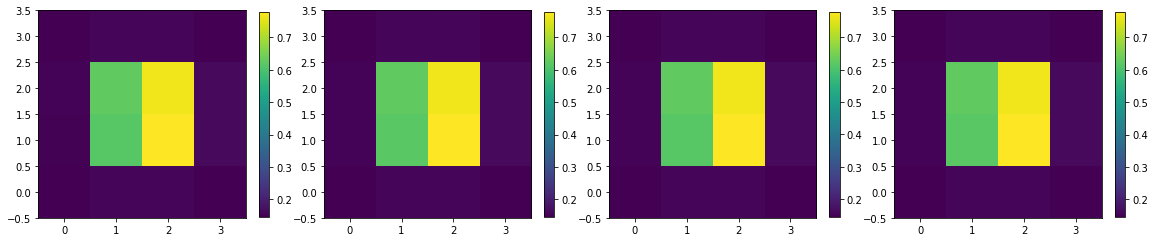

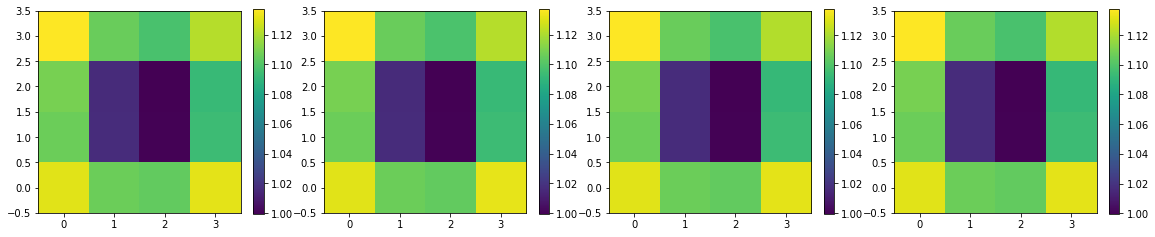

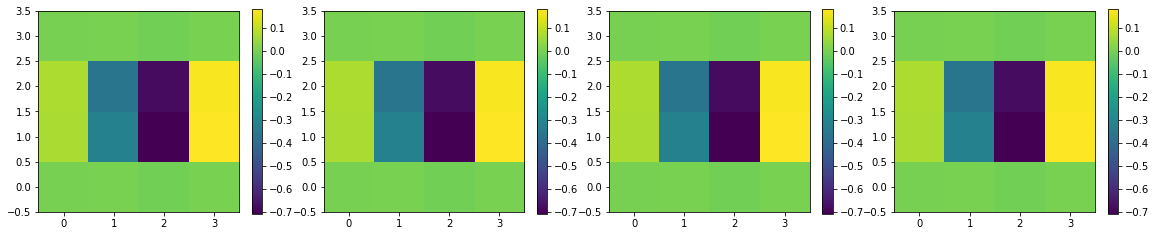

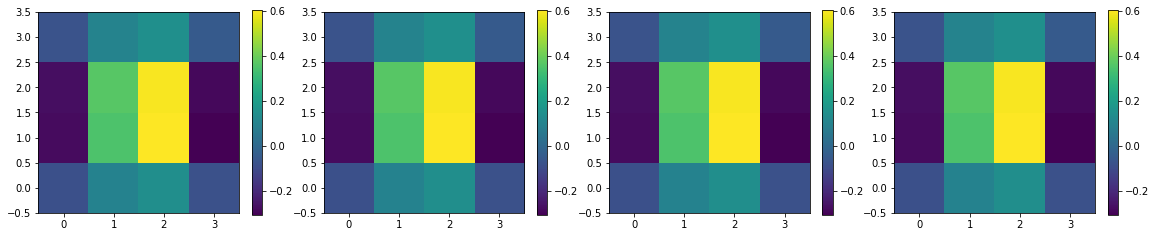

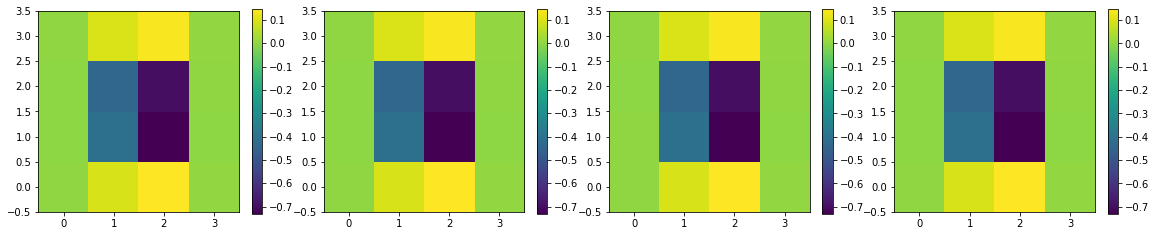

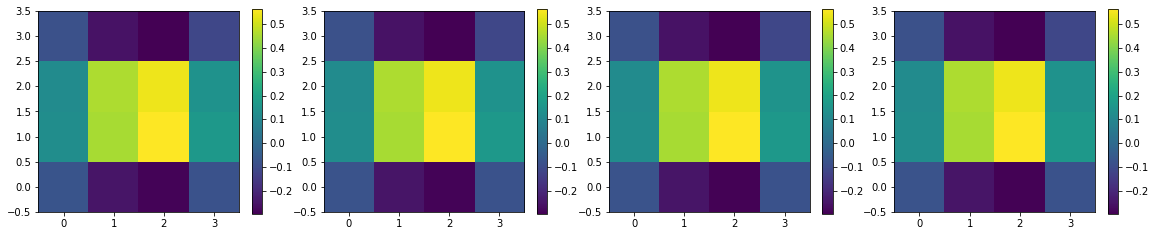

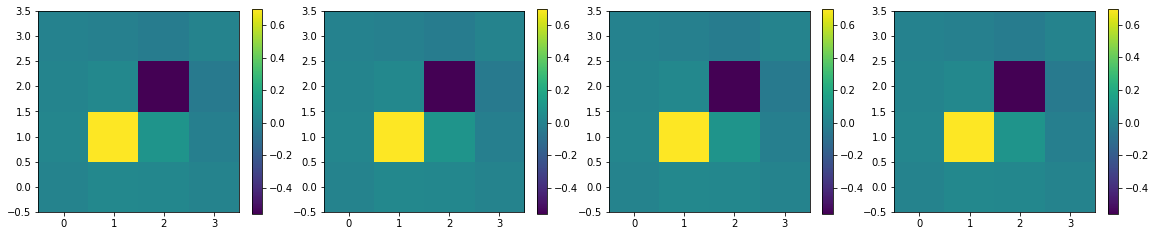

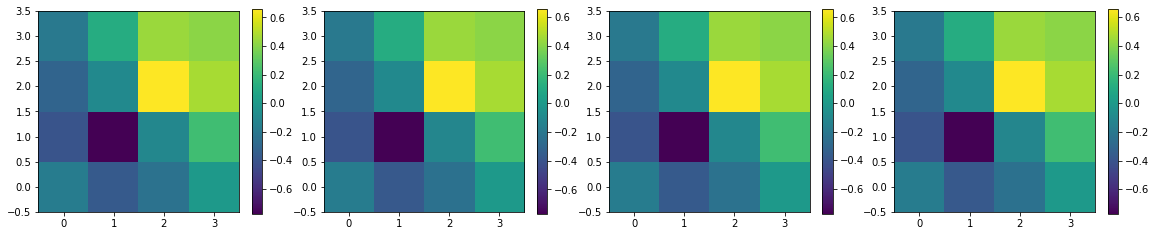

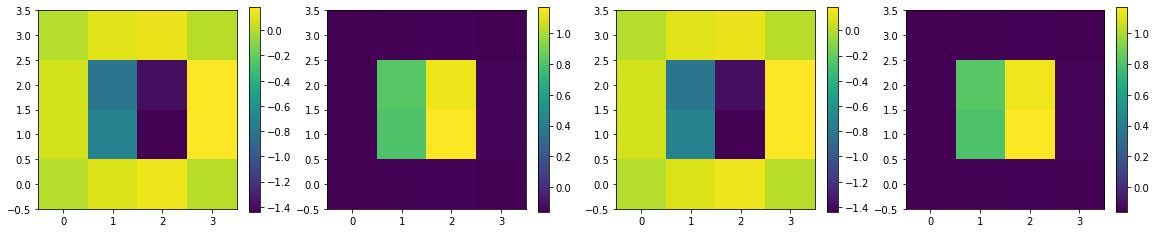

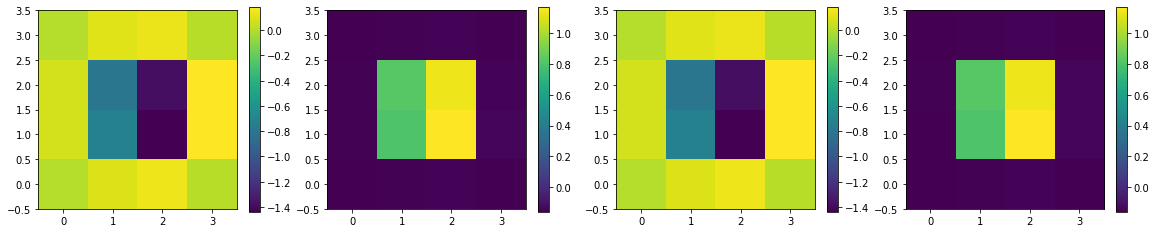

In [45]:
def p(m1, m2,  m3, m4):
    _ = plt.figure(figsize=(16,6))
    plt.subplot(141)
    plt.imshow(m1,
               origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(142)
    plt.imshow(m2,
               origin='lower')
    plt.colorbar(shrink=.5)

    plt.subplot(143)
    plt.imshow(m3.reshape(block_x, block_y).T,
               origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(144)
    plt.imshow(m4.reshape(block_x, block_y).T,
               origin='lower')
    plt.colorbar(shrink=.5)
    plt.tight_layout()
    plt.show()
p(u1, u2, obs_outputs[:block_size,0], obs_outputs[block_size:,0])
p(v1, v2, obs_outputs[:block_size,1], obs_outputs[block_size:,1])
p(u_xx1, u_xx2, der_u_outputs[:block_size,0], der_u_outputs[block_size:,0])
p(v_xx1, v_xx2, der_v_outputs[:block_size,0], der_v_outputs[block_size:,0])
p(u_yy1, u_yy2, der_u_outputs[:block_size,1], der_u_outputs[block_size:,1])
p(v_yy1, v_yy2, der_v_outputs[:block_size,1], der_v_outputs[block_size:,1])
p(u_t1, u_t2, der_u_outputs[:block_size,2], der_u_outputs[block_size:,2])
p(v_t1, v_t2, der_v_outputs[:block_size,2], der_v_outputs[block_size:,2])

p(u_xx1+u_yy1, (v_xx1+v_yy1), dataset['diff_output'][:block_size,0], dataset['diff_output'][:block_size,1])
p(u_xx2+u_yy2, (v_xx2+v_yy2), dataset['diff_output'][block_size:,0], dataset['diff_output'][block_size:,1])

In [43]:
from scipy.optimize import lsq_linear
from scipy import linalg

In [338]:
params = np.array([rho_u, D, rho_v])

In [354]:
params2 = np.array([pde_resKM.rho_u.get_value(0).numpy()[0], 
                    pde_resKM.D.get_value(0).numpy()[0], 
                    pde_resKM.rho_v.get_value(0).numpy()[0]])

In [355]:
n =  simulation.n[0]*simulation.n[1]
l = simulation.L[0]*simulation.L[1]
n2 = 2*block_size

u_sol = u.numpy().flatten()
v_sol = v.numpy().flatten()

kappa_sol = pde_resKM.kappa_u.get_value(0).numpy()[0]

f_sol = u_sol * u_sol * v_sol / (1.0 + kappa_sol * u_sol * u_sol)


uxxyy_sol = (u_xx.numpy() + u_yy.numpy()).flatten()
vxxyy_sol = (v_xx.numpy() + v_yy.numpy()).flatten()/10

A_sol = np.vstack((np.c_[f_sol,  [0]*n2,  [0]*n2],
                   np.c_[[0]*n2,  vxxyy_sol, -f_sol]))


u_dt_sol = (u_t.numpy()/100).flatten()
v_dt_sol = (v_t.numpy()/1000).flatten()

b_sol = np.r_[(uxxyy_sol-u_dt_sol-u_sol+1, -v_dt_sol+1)]
#b_sol = np.r_[(uxxyy_sol, vxxyy_sol)]

In [356]:
np.sqrt(np.mean(((np.dot(A_sol, params)+b_sol))**2))

0.012888034596179841

In [357]:
np.sqrt(np.mean(((np.dot(A_sol, params2)+b_sol))**2))

8.206002896477086e-05

In [358]:
params3 = linalg.solve(np.dot(A_sol.T,A_sol), -np.dot(A_sol.T,b_sol))
params3

array([1.95058623e-02, 9.77675650e+01, 1.47502555e-02])

In [359]:
np.sqrt(np.mean(((np.dot(A_sol, params3)+b_sol))**2))

4.9839658476115134e-05

In [360]:
params2

array([1.9505853e-02, 9.7756248e+01, 1.4748963e-02], dtype=float32)

In [279]:
kappa_u

0.010000000000000002

In [82]:
np.max(u_actual)-np.min(u_actual)

6.341826562258701

In [208]:
print(np.mean((der_v_outputs[:test_size, 0] - v_xx.numpy())**2))
print(np.mean((der_v_outputs[:test_size, 1] - v_yy.numpy())**2))

0.0009904267918598244
0.000986807834585626


In [248]:
np.sqrt(0.00097)/np.sqrt(np.max(der_v_outputs[:test_size, 0]**2 ))

0.12872605200828996

In [249]:
np.sqrt(0.00097)/np.sqrt(np.mean(der_v_outputs[:test_size, 0]**2 ))

0.2637518238175379

In [241]:
np.max(der_v_outputs[:test_size, 0]+der_v_outputs[:test_size, 1]) - np.min(der_v_outputs[:test_size, 0]+der_v_outputs[:test_size, 1]) 

0.5324497151440455

In [282]:
test_size = 32
u_actual = u.numpy().flatten()
v_actual = v.numpy().flatten()

kappa_sol = pde_resKM.kappa_u.get_value(0).numpy()[0]

f_actual = u_actual * u_actual * v_actual / (1.0 + kappa_sol * u_actual * u_actual)


uxxyy_actual = (u_xx.numpy() + u_yy.numpy()).flatten()

#(v_xx.numpy() + v_yy.numpy()).flatten()/10
vxxyy_actual = (der_v_outputs[:test_size, 0] + #np.random.normal(0, .05, test_size)+
                der_v_outputs[:test_size, 1]).flatten()/10
vxxyy_actual = (v_xx.numpy() + v_yy.numpy()).flatten()/10

A_actual = np.vstack((np.c_[f_actual,  [0]*test_size,  [0]*test_size],
                      np.c_[[0]*test_size,  vxxyy_actual, -f_actual]))


u_dt_actual = (u_t.numpy()/100).flatten()
v_dt_actual = (v_t.numpy()/1000).flatten()

b_actual = np.r_[(uxxyy_actual-u_dt_actual-u_actual+1, -v_dt_actual+1)]

In [283]:
params4 = linalg.solve(np.dot(A_actual.T,A_actual), -np.dot(A_actual.T,b_actual))
params4

array([1.96889015e-02, 6.07703016e+01, 1.06397409e-02])

In [172]:
test_size = 32
u_actual = obs_outputs[:test_size, 0]
v_actual = obs_outputs[:test_size, 1]

kappa_sol = pde_resKM.kappa_u.get_value(0).numpy()[0]

f_actual = u_actual * u_actual * v_actual / (1.0 + kappa_sol * u_actual * u_actual)


uxxyy_actual = (der_u_outputs[:test_size, 0] + der_u_outputs[:test_size, 1])
vxxyy_actual = (der_v_outputs[:test_size, 0] + der_v_outputs[:test_size, 1]).flatten()/10

A_actual = np.vstack((np.c_[f_actual,  [0]*test_size,  [0]*test_size],
                      np.c_[[0]*test_size,  vxxyy_actual, -f_actual]))


u_dt_actual = (der_u_outputs[:test_size, 2] /100)
v_dt_actual = (der_v_outputs[:test_size, 2] /1000)

b_actual = np.r_[(uxxyy_actual-u_dt_actual-u_actual+1, -v_dt_actual+1)]

In [173]:
params4 = linalg.solve(np.dot(A_actual.T,A_actual), -np.dot(A_actual.T,b_actual))
params4

array([1.97328100e-02, 9.94934181e+01, 1.51207473e-02])

In [284]:
def add_noise(noise_level = 0, kappa_sol = None):
    test_size = 33
    u_actual = obs_outputs[:test_size, 0].copy() 
    v_actual = obs_outputs[:test_size, 1].copy()    
    test_size = len(u_actual)
    
    if kappa_sol is None:
        kappa_sol = pde_resKM.kappa_u.get_value(0).numpy()[0]

    f_actual = u_actual * u_actual * v_actual / (1.0 + kappa_sol * u_actual * u_actual)


    uxxyy_actual = (der_u_outputs[:test_size, 0] + der_u_outputs[:test_size, 1])    
    
    
    if noise_level > 0:
        v_xx_band = np.max(der_v_outputs[:test_size, 0])-np.min(der_v_outputs[:test_size, 0])
        v_yy_band = np.max(der_v_outputs[:test_size, 1])-np.min(der_v_outputs[:test_size, 1])
        vxx_actual = der_v_outputs[:test_size, 0] + np.random.normal(0, v_xx_band*noise_level , test_size)
        vyy_actual = der_v_outputs[:test_size, 1] + np.random.normal(0, v_yy_band*noise_level , test_size)
        vxxyy_actual =(vxx_actual + vyy_actual).flatten()/10        
    else:
        vxx_actual = der_v_outputs[:test_size, 0]
        vyy_actual = der_v_outputs[:test_size, 1]
        vxxyy_actual = (der_v_outputs[:test_size, 0] + der_v_outputs[:test_size, 1]).flatten()/10

    A_actual = np.vstack((np.c_[f_actual,  [0]*test_size,  [0]*test_size],
                          np.c_[[0]*test_size,  vxxyy_actual, -f_actual]))


    u_dt_actual = (der_u_outputs[:test_size, 2] /100)
    v_dt_actual = (der_v_outputs[:test_size, 2] /1000)

    b_actual = np.r_[(uxxyy_actual-u_dt_actual-u_actual+1, -v_dt_actual+1)]
    params_pred = linalg.solve(np.dot(A_actual.T,A_actual), -np.dot(A_actual.T,b_actual))
    
    v_xx_err = np.mean((der_v_outputs[:test_size, 0] - vxx_actual)**2)
    v_yy_err = np.mean((der_v_outputs[:test_size, 1] - vyy_actual)**2)    
    return tuple(params_pred.tolist() )+ (v_xx_err, v_yy_err)
    

In [201]:
print(np.mean((der_v_outputs[:test_size, 0] - v_xx.numpy())**2))
print(np.mean((der_v_outputs[:test_size, 1] - v_yy.numpy())**2))

0.0009904267918598244
0.000986807834585626


In [285]:
noise_levels = np.linspace(0,.3, 100)
ensumble_n = 100
for n in range(ensumble_n):
    if n == 0:
        estimates = np.array([add_noise(n_l) for n_l in noise_levels])
    else:
        estimates += np.array([add_noise(n_l) for n_l in noise_levels])
        
estimates /= ensumble_n

In [286]:
estimates.shape

(100, 5)

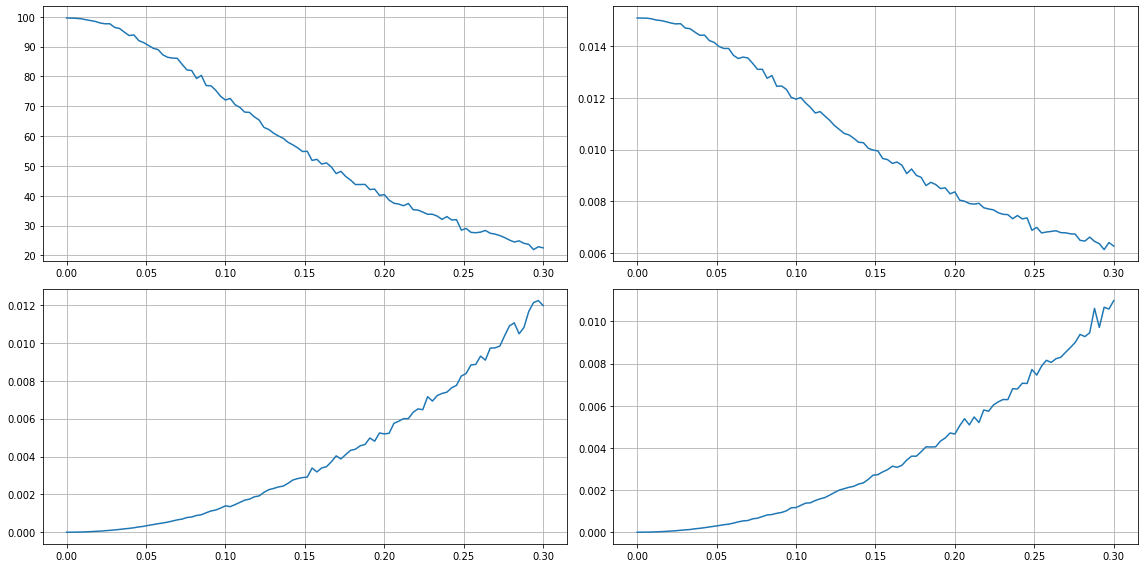

In [287]:
_ = plt.figure(figsize=(16, 8))
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,i*2+j+1)
        plt.plot(noise_levels, estimates[:, i*2+j+1])        
        plt.grid()
plt.tight_layout()
plt.show()

In [138]:
add_noise(0)

(0.01973280997722836,
 99.49341812882234,
 0.015120747280319324,
 0.0,
 0.0,
 3.7494859510203646e-06,
 8.287541347416645e-07)

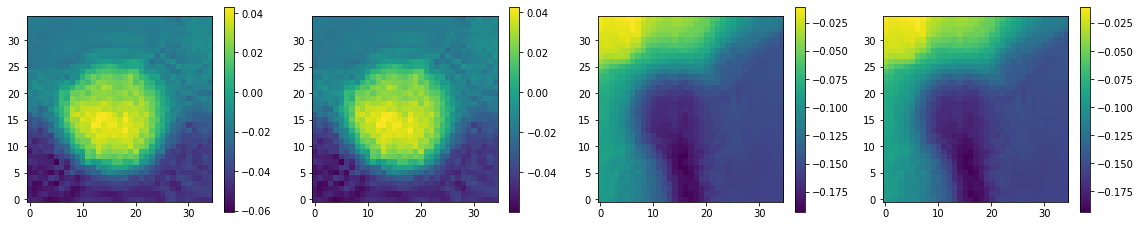

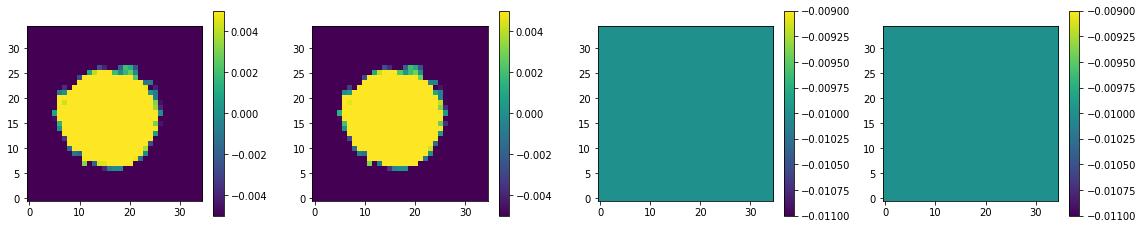

In [56]:
res1=(np.dot(A_sol, params2)+b_sol
     )[:block_size].reshape(block_x, block_y).T
res2=(np.dot(A_sol, params2)+b_sol
     )[block_size:2*block_size].reshape(block_x, block_y).T
res3=(np.dot(A_sol, params2)+b_sol
     )[2*block_size:3*block_size].reshape(block_x, block_y).T
res4=(np.dot(A_sol, params2)+b_sol
     )[3*block_size:].reshape(block_x, block_y).T
p(res1,res2,res3,res4)
thres1=0.005
thres2=-0.005
res1[res1 > thres1] = thres1
res1[res1 < thres2] = thres2
res2[res2 > thres1] = thres1
res2[res2 < thres2] = thres2
thres1=0.01
thres2=-0.01
res3[res3 > thres1] = thres1
res3[res3 < thres2] = thres2
res4[res4 > thres1] = thres1
res4[res4 < thres2] = thres2
p(res1,res2,res3,res4)

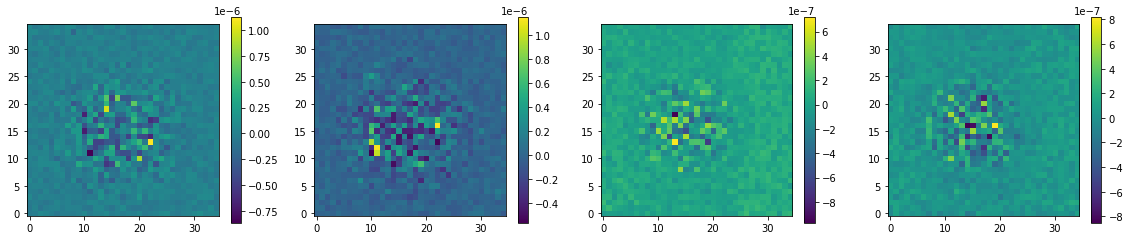

In [57]:
fu_sol, fv_sol = pde_resKM.residual(pinnKM, test_d)
res1=(np.dot(A_sol, params2)+b_sol
     )[:block_size].reshape(block_x, block_y).T
res2=(np.dot(A_sol, params2)+b_sol
     )[block_size:2*block_size].reshape(block_x, block_y).T
res3=(np.dot(A_sol, params2)+b_sol
     )[2*block_size:3*block_size].reshape(block_x, block_y).T
res4=(np.dot(A_sol, params2)+b_sol
     )[3*block_size:].reshape(block_x, block_y).T
p(res1+fu_sol.numpy()[:block_size].reshape(block_x, block_y).T,
  res2+fu_sol.numpy()[block_size:].reshape(block_x, block_y).T,
  res3+fv_sol.numpy()[:block_size].reshape(block_x, block_y).T,
  res4+fv_sol.numpy()[block_size:].reshape(block_x, block_y).T,)

In [61]:
res_obs = lsq_linear(A_sol, b_sol, bounds=(0.0, np.inf), tol=1e-16)
res_obs

 active_mask: array([-1, -1, -1])
        cost: 16551.379752990466
         fun: array([ 0.55743337,  0.55322146,  0.55879426, ..., -0.99963897,
       -0.99963588, -0.99964142])
     message: 'The first-order optimality measure is less than `tol`.'
         nit: 13
  optimality: 4.320909614557874e-28
      status: 1
     success: True
           x: array([1.27266364e-46, 2.09048140e-28, 8.46731860e-48])

In [269]:
n =  simulation.n[0]*simulation.n[1]
l = simulation.L[0]*simulation.L[1]
n2 = 2*block_size
u_obs = obs_outputs[:,0].flatten()
v_obs = obs_outputs[:,1].flatten()
f_obs = u_obs * u_obs * v_obs / (1.0 + simulation.parameters['kappa_u'] * u_obs * u_obs)
A_obs = np.vstack((np.c_[f_obs, -u_obs, [1]*n2, [0]*n2, [0]*n2],
                   np.c_[[0]*n2, [0]*n2, [0]*n2, -f_obs, [1]*n2]))

uxxyy_obs =simulation.Ds[0] *  (der_u_outputs[:,0] + der_u_outputs[:,1]).flatten()
vxxyy_obs =simulation.Ds[1] *  (der_v_outputs[:,0] + der_v_outputs[:,1]).flatten()
u_dt = der_u_outputs[:,2].flatten()
v_dt = der_v_outputs[:,2].flatten()

b_obs = np.r_[(uxxyy_obs-u_dt, vxxyy_obs-v_dt)]

In [169]:
np.sqrt(np.mean(((np.dot(A_obs, params)+b_obs))**2))

4.3139633449820096e-07

In [303]:
res_obs = lsq_linear(A_obs, b_obs, bounds=(0, np.inf), tol=1e-16)
res_obs

 active_mask: array([-1,  0,  0, -1,  0])
        cost: 55.98322605362867
         fun: array([0.01198398, 0.01190489, 0.01179273, ..., 0.13051092, 0.13049243,
       0.1304939 ])
     message: 'The relative change of the cost function is less than `tol`.'
         nit: 9
  optimality: 1.7763568394002505e-14
      status: 2
     success: True
           x: array([2.11852294e-033, 7.28018337e-002, 2.27743983e-002, 4.94065646e-324,
       6.59956339e-002])

In [136]:
b_obs = np.r_[(uxxyy_obs, vxxyy_obs)]

In [160]:
res1=(np.dot(A_obs, params2)+b_obs
     )[:block_size].reshape(block_x, block_y).T
res2=(np.dot(A_obs, params2)+b_obs
     )[block_size:2*block_size].reshape(block_x, block_y).T
res3=(np.dot(A_obs, params2)+b_obs
     )[2*block_size:3*block_size].reshape(block_x, block_y).T
res4=(np.dot(A_obs, params2)+b_obs
     )[3*block_size:].reshape(block_x, block_y).T

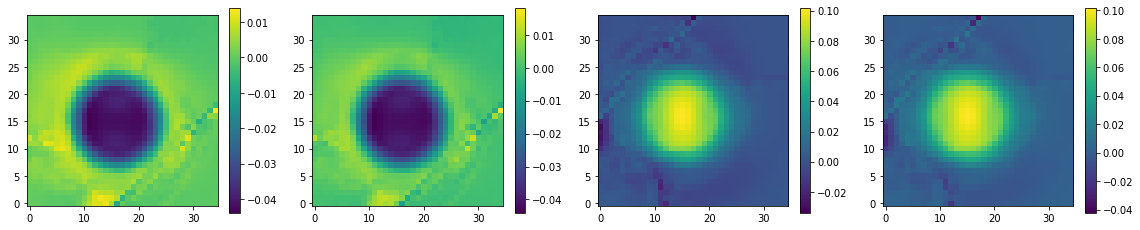

In [161]:
p(res1,res2,res3,res4)

In [380]:
import rdsolver

In [403]:
# Load a standard ASDM model
D, beta, gamma, f, f_args, homo_ss = rdsolver.models.asdm()

# Set up the space and time grid
n = simulation.n#(32, 32)
L = simulation.L#(50, 50)
t = np.linspace(0, 2*768, 10)#t_star#np.linspace(0, 100000, 256)

# Include the estimated params
D_a = simulation.Ds[0]#pde_lossKM..numpy()#0.01558*const1#0.005
D_s = simulation.Ds[1]#pde_lossKM.D_s.numpy()#0.03886*const2#0.2
D[0] = D_a # D_a
D[1] = D_s # D_s
beta[0] = pde_resKM.sigma_u.get_value(0).numpy()[0]#pde_lossKM.sigma_a.numpy()#0.00040#0.00097*const1# sigma_a
beta[1] = pde_resKM.sigma_v.get_value(0).numpy()[0]#pde_lossKM.sigma_s.numpy()#0.01521#0.00345*const2 # sigma_s
gamma[0,0] = -pde_resKM.mu_u.get_value(0).numpy()[0]#-pde_lossKM.mu_a.numpy()#-0.01046#-0.03316*const1#mu_a
# rho_a,  rho_s, kappa_a
f_args = (pde_resKM.rho_u.get_value(0).numpy()[0],
          pde_resKM.rho_v.get_value(0).numpy()[0],
          pde_resKM.kappa_u.get_value(0).numpy()[0])
#(pde_lossKM.rho_a.numpy(), pde_lossKM.rho_s.numpy(), pde_lossKM.kappa_a.numpy())


# Initial condition and solve
#c0 = rdsolver.initial_condition(uniform_conc=homo_ss, n=n, L=L)
#c0 = data[:, :, :, 0]
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_9/Koch_Meinhardt_9.npy")
with open(data_path, 'rb') as f1:
    aux_data = np.load(f1)
c0 = aux_data[:, :, :, 1]
c = rdsolver.solve(c0, t, D=D, beta=beta, gamma=gamma, f=f, f_args=f_args, L=L)


100%|██████████| 10/10 [01:26<00:00,  8.61s/it]


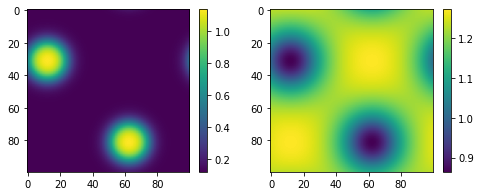

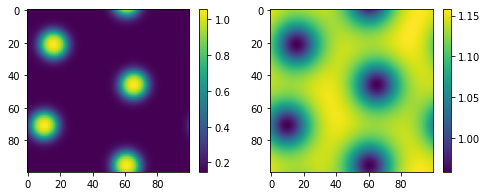

In [406]:
_ = plt.figure(figsize=(8,4))
plt.title("Solution by estimates")
plt.subplot(121)
plt.imshow(c[0, :,:,-1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(c[1, :,:,-1])
plt.colorbar(shrink=.75)
plt.show()
_ = plt.figure(figsize=(8,4))
plt.title("Solution")
plt.subplot(121)
plt.imshow(aux_data[0, :,:,-1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(aux_data[1, :,:,-1])
plt.colorbar(shrink=.75)
plt.show()

In [388]:
simulation

Simulation(name='Koch_Meinhardt_9', n=(100, 100), L=(8, 8), Ds=(0.01, 1.0), dt=0.001, t_start=0, t_end=768.0, t_steps=769, dt_arr=None, parameters={'kappa_u': 1.0, 'mu_u': 1.0, 'rho_u': 1.95, 'rho_v': 1.5, 'sigma_u': 0.1, 'sigma_v': 0.1}, steady_state_func=None, perturbation_size=0.1, kinetic_func=None, tol=0.001, sample_parameters=True, sample_parameters_num=10, sample_parameters_std=(0.0, 0.01, 0.01, 0.01, 0.001, 0.001), same_init=True, c0=None)

In [421]:
# Load a standard ASDM model
D, beta, gamma, f, f_args, homo_ss = rdsolver.models.asdm()

# Set up the space and time grid
n = simulation.n#(32, 32)
L = simulation.L#(50, 50)
t = np.linspace(0, 4*768, 10)#t_star#np.linspace(0, 100000, 256)

# Include the estimated params
D_a = simulation.Ds[0]#pde_lossKM..numpy()#0.01558*const1#0.005
D_s = simulation.Ds[1]#pde_lossKM.D_s.numpy()#0.03886*const2#0.2
D[0] = D_a # D_a
D[1] = D_s # D_s
beta[0] = 4*simulation.parameters["sigma_u"]#pde_lossKM.sigma_a.numpy()#0.00040#0.00097*const1# sigma_a
beta[1] = simulation.parameters["sigma_v"]#pde_lossKM.sigma_s.numpy()#0.01521#0.00345*const2 # sigma_s
gamma[0,0] = -4*simulation.parameters["mu_u"]#-pde_lossKM.mu_a.numpy()#-0.01046#-0.03316*const1#mu_a
# rho_a,  rho_s, kappa_a
f_args = (4*simulation.parameters["rho_u"],
          simulation.parameters["rho_v"],
          simulation.parameters["kappa_u"])
#(pde_lossKM.rho_a.numpy(), pde_lossKM.rho_s.numpy(), pde_lossKM.kappa_a.numpy())


# Initial condition and solve
#c0 = rdsolver.initial_condition(uniform_conc=homo_ss, n=n, L=L)
#c0 = data[:, :, :, 0]
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_9/Koch_Meinhardt_9.npy")
with open(data_path, 'rb') as f1:
    aux_data = np.load(f1)
c0 = aux_data[:, :, :, 1]
c = rdsolver.solve(c0, t, D=D, beta=beta, gamma=gamma, f=f, f_args=f_args, L=L)


100%|██████████| 10/10 [02:05<00:00, 12.55s/it]


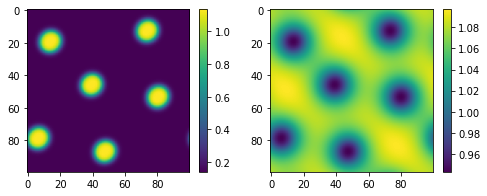

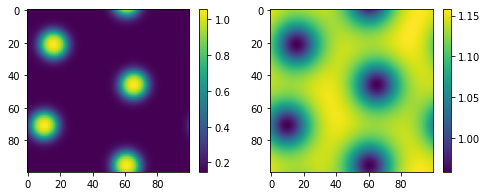

In [422]:
_ = plt.figure(figsize=(8,4))
plt.title("Solution by estimates")
plt.subplot(121)
plt.imshow(c[0, :,:,-1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(c[1, :,:,-1])
plt.colorbar(shrink=.75)
plt.show()
_ = plt.figure(figsize=(8,4))
plt.title("Solution")
plt.subplot(121)
plt.imshow(aux_data[0, :,:,-1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(aux_data[1, :,:,-1])
plt.colorbar(shrink=.75)
plt.show()

In [407]:
print(pde_resKM.trainables_str())

sigma_u: 0.03358 sigma_v: 0.08917 mu_u: 0.38960 rho_u: 0.74692 
rho_v: 1.29434 kappa_u: 0.75477 


In [408]:
simulation.parameters

{'kappa_u': 1.0,
 'mu_u': 1.0,
 'rho_u': 1.95,
 'rho_v': 1.5,
 'sigma_u': 0.1,
 'sigma_v': 0.1}

In [412]:
(1/0.38960)#*0.03358

2.566735112936345

In [414]:
2.5*0.74692 

1.8673000000000002

In [268]:
minimize_parameters(pde_resKM, pinnKM, test_d, [pde_resKM.rho_u, pde_resKM.rho_v, pde_resKM.kappa_u], 
                    method="Nelder-Mead", tol=1e-9 )

 final_simplex: (array([[0.02013884, 0.06914701, 0.0114    ],
       [0.02013884, 0.06914701, 0.0114    ],
       [0.02013884, 0.06914701, 0.0114    ],
       [0.02013884, 0.06914701, 0.0114    ]]), array([4.10391617, 4.10391617, 4.10391617, 4.10391617]))
           fun: 4.103916168212891
       message: 'Optimization terminated successfully.'
          nfev: 231
           nit: 119
        status: 0
       success: True
             x: array([0.02013884, 0.06914701, 0.0114    ])

In [62]:
import copy

In [81]:

pde_resKM2 = copy.deepcopy(pde_resKM) 

In [82]:

@tf.function
def resi4(v1, v2):
    pde_resKM2.D.set_value(v1)
    pde_resKM2.rho_v.set_value(v2)
    return pde_resKM2.residual(pinnKM, test_d)   

In [156]:
D_range = np.linspace(40, 80, 30)
rho_v_range = np.linspace(.01, .012, 30)

D_mesh, rho_v_mesh = np.meshgrid(D_range, rho_v_range)

In [157]:
v_res = np.zeros_like(rho_v_mesh)
l2_norm = L2()
for i, _ in enumerate(D_mesh):    
    
    for j, _ in enumerate(rho_v_mesh):
        v1 = D_mesh[i,j]
        v2 = rho_v_mesh[i,j]        
        
        test_pde_u, test_pde_v = resi4(v1.astype(np.float32), v2.astype(np.float32))        
        
        v_res[i,j] = l2_norm.reduce_norm((test_pde_v,)).numpy()[0]
        

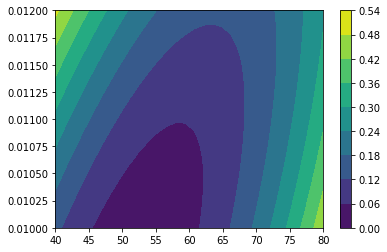

In [159]:
#_ = plt.figure(figsize=(16,4))

plt.contourf(D_range, rho_v_range, v_res)
#plt.imshow(v_res)
plt.colorbar()

plt.show()


In [160]:
print(pde_resKM.trainables_str())

D: 52.67937 rho_u: 0.02041 rho_v: 0.00995 kappa_u: 0.01109 



In [161]:
pde_resKM.outputs_correction_fact

ListWrapper([<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.01>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1>, <tf.Tensor: shape=(), dtype=float32, numpy=0.001>])

In [167]:
@tf.function
def resi2():
    outputs = pinnKM.net(test_d)
    u, v, u_xx, u_yy, u_t, v_xx, v_yy, v_t = (
        outputs[:, 0] * pde_resKM.outputs_correction_fact[0],
        outputs[:, 1] * pde_resKM.outputs_correction_fact[1],
        outputs[:, 2] * pde_resKM.outputs_correction_fact[2],
        outputs[:, 3] * pde_resKM.outputs_correction_fact[3],
        outputs[:, 4] * pde_resKM.outputs_correction_fact[4],
        outputs[:, 5] * pde_resKM.outputs_correction_fact[5],
        outputs[:, 6] * pde_resKM.outputs_correction_fact[6],
        outputs[:, 7] * pde_resKM.outputs_correction_fact[7],
    )
    D = pde_resKM.D.get_value(0)        
    rho_v = pde_resKM.rho_v.get_value(0)
    kappa_u = pde_resKM.kappa_u.get_value(0)
    f = u * u * v / (1.0 + kappa_u * u * u)
    return (v_t - 1, v_xx + v_yy, f)

In [168]:
kappa_u

0.010000000000000002

In [169]:

#pde_resKM.kappa_u.set_value(0.01136 )
pde_resKM.kappa_u.set_value(kappa_u)
a, d, b = resi2()

In [165]:

f_sol = u_sol * u_sol * v_sol / (1.0 + kappa_sol * u_sol * u_sol)
A_sol =  f_sol

vxxyy_sol = D * (v_xx.numpy() + v_yy.numpy()).flatten()/10
v_dt_sol = (v_t.numpy()/1000).flatten()

b_sol = v_dt_sol-vxxyy_sol-1

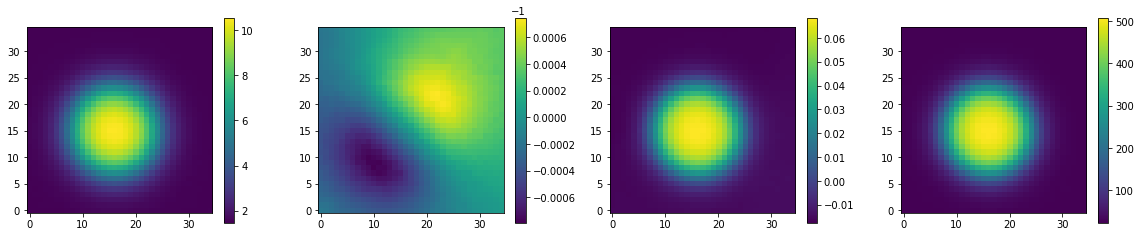

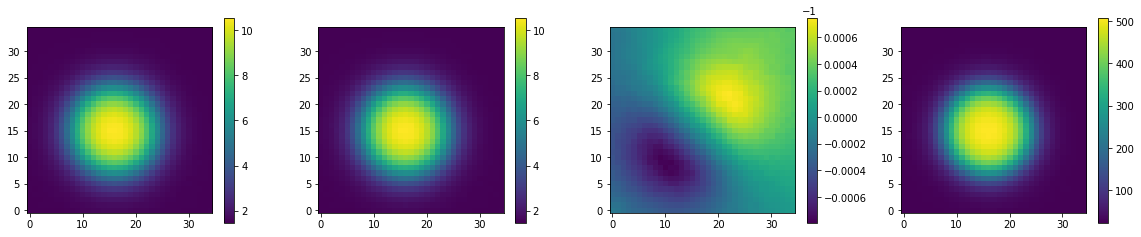

In [171]:
p(u1,  a.numpy()[:block_size].reshape(block_x, block_y).T,d.numpy()[:block_size], b.numpy()[:block_size])
p(u1, u2, a.numpy()[block_size:], b.numpy()[block_size:])
#p(u1, u2, a.numpy()[:block_size]/b.numpy()[:block_size], a.numpy()[block_size:]/b.numpy()[block_size:])
#p(u1, u2, b_sol[block_size:], A_sol[block_size:] )

In [102]:
A_sol[2*block_size:, 1].shape

(2450,)

In [104]:
b_sol[2*block_size:].shape

(2450,)